# Coursework 1: 

## Predicting gestational age at scan for neonates from the developing Human Connectome Project

In this coursework we ask you to put into practice to practice the foundational theoertical skills and practical PyTorch coding techniques we taught you in lectures 1-4 as well as the content on network interpretability (Lecture 7). This will test your understanding of how to design, create and train effective deep architectures in future, as well as how to perform appropriate pre-processing, data augmentation and visualisation to maximise the accuracy, generalisability and interpretability of your models.

The coursework will be performed open book but under exam conditions in the lab. We will expect you to:

1. Create a custom DataSet from which you sample batches at random using a DataLoder
2. Design and implement appropriate augmentations so as to maximise the performance of your model on a left out set
3. Create a DataLoader that samples from the dataset with augmentation
4. Create a custom ResNet (He 2015, 2016) in order to perform perform regression. 
   - A create a ResNet class to fit a prescribed design
   - B Load your network to the device; select an appropriate loss function and optimiser
5. Write a training loop
6. Visualise the outputs of your network to evaluate whether your network is learning appropriate features.
 
We will start this coursework open book in class. We ask you to hand in what you have done in class but you will have until 20/02/2020 for full submission. 

If you have not done so already please sign the dHCP user agreement and upload a screenshot as evidence with your coursework submission. Failure to do so will mean that your coursework will not be marked. Please find the link at this [location](http://www.developingconnectome.org/data-release/information-registration-and-download/) (you can sign it after the session; if you have any problems at all let me know).

## The Data

The cerebral cortex is a thin layer of tissue at the outer surface of the brain, where most cells responsible for higher-order cognitive processing are found. The creation and maturation of these cells develops rapidly during fetal and early neonatal development (in the weeks and months just before and after birth), which leads to cortical folding and dramatic changes in the observed intensities of T1 and T2-weighted Magnetic Resonance Imaging (MRI). In this exercise you will use different MRI-derived metrics of cortical maturation to predict the gestational age at scan of babies scanned as part of the Developing Human Connectome Project (dHCP, Makropoulos et al 2018).

We will use metrics of cortical thickness, cortical curvature and cortical myelination generated from mesh models of the cortical surface. While we will explore Geometric Deep Learning (for direct analysis of surface imaging data) in the last lecture of  course. Right now you will work with files which have been projected to 2D via the sphere:

<img src="https://drive.google.com/uc?id=14pIpXV8UvH-zf_u_lJntZjf2o5devGNF" alt="Drawing" style="width: 100px;"/>

Below A, shows the original cortical maps, B shows the maps as you will view them with MatplotLib and C shows the type of regression result you might expect if you trained your network long enough.

<img src="https://drive.google.com/uc?id=1cUf1pMttW36vS8Fr8rcTX0sNtjd66cQs" alt="Drawing" style="width: 800px;"/>

The data is available from this shared Google Drive [link](https://drive.google.com/drive/folders/1vkOpjOHRNOUUfn-U1jDUCpAo5VYi6hG0?usp=sharing). Once you access the link the folder should be accessible from your Google Drive. From there you can develop your code using [Google Colab](https://colab.research.google.com/)

## Using shared folders in Google Colab

Note, it is possible to access data from a shared google drive/files so long as you first add it to your drive.

To do this:
- log into google drive and accept the invitation to share the folder/file. You should see the folder 'coursework1-data' under "shared with me" on the left side. 
- Click on the folder / file so that they turn blue and are highlighted (do not enter the folder)
- Click on the three vertical dots and click "Add to My Drive".

Now mount **your** drive and you should see the data under "/content/My Drive"

Note, if you have accidentally mounted already and then you add drive, it wont refresh unless you pass force_remount = True argument to drive.mount i.e 

`drive.mount('/content/drive', force_remount= True)`

**NOTE** you are going to need to copy the Notebook - or upload the versions from Keats and edit separately. You shouldn't be able to save to the Drive, but hopefully it goes without saying that you shouldn't be saving your work to a shared folder. Please check during the session that everything works for you!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now cd into the shared folder and import all the necessary modules and helper functions

In [2]:
%cd /content/drive/My Drive/Uni stuff/KCL/Advanced Machine Learning/Coursework 1
%matplotlib inline
!pip3 install SimpleITK

import time
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torchvision
import scipy.misc
import imageio
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import resize
from torchvision import transforms, utils

import time
import seaborn as sns
import BsplineAugmentation as bspline

# initialize network weights as a gaussian
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

save_path = 'results'

if not os.path.exists(save_path):
    os.makedirs(save_path)

/content/drive/My Drive/Uni stuff/KCL/Advanced Machine Learning/Coursework 1
     |████████████████████████████████| 42.5MB 72kB/s 


Note: `weights_init` is a function for network weight initialisation.

The image data is avaiable in the subfolder `coursework1_colab/cortical_training_data`. Each file is a $240 \times 320 \times 3 $ numpy array, containing 3 $240\times 320$ 2D projections of the cortical surface imaging features. The files are pickled and saved as `.npy` numpy arrays.

All the labels are found in the `coursework1_colab/Training_labels.pkl` file, a 3 column pandas dataframe that contains subject and session ids (as explained in the tutorial for Lecture 2). The final column is the target label, 'scan_ga'.

Try reading in a single file and viewing the dataframe in the cell below. You can also use `matplotlib.plt.imshow` to view 2D slices of the image.

     subj_id  scan_ga
0          0     39.4
1          1     44.1
2          2     41.6
3          3     40.6
4          4     43.3
..       ...      ...
501      501     44.0
502      502     40.6
503      503     26.6
504      504     41.2
505      505     41.5

[506 rows x 2 columns]
10.0


Text(0.5, 1.0, 'GA-scan: 41.0')

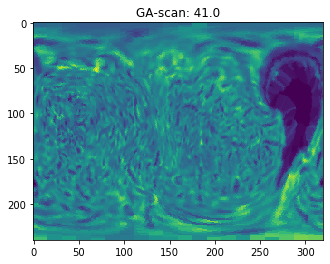

In [3]:
### cell/for testing file input/output/visualisation

# Set paths
IMAGE_PATH = 'coursework1-data/2D_projection_R_sub-50.npy'
LABEL_PATH = 'Training_meta.pkl'
INDEX_EXAMPLE = 10
LABEL_COLUMN_NAME = 'scan_ga'
LABEL_SUBJ_ID = 'subj_id'

# Load from numpy
imageExample = np.load(IMAGE_PATH)
imageExample = torch.from_numpy(imageExample).to(torch.float) 

# Load the meta file
meta = pd.read_pickle(LABEL_PATH)
print(meta)

#Extract the lavbels from the image
metaLocation = meta.loc[INDEX_EXAMPLE]
exampleLabel = metaLocation[LABEL_COLUMN_NAME]
print(metaLocation[LABEL_SUBJ_ID])

#Plot the image and the label
plt.imshow(imageExample[:,:,0])
plt.title('GA-scan: {}' .format(exampleLabel))



## Exercise 1: Create a Custom DataLoader

Using the example from Lecture 2 as a guide, complete the below function to create a custom DataLoader for the 2D cortical projection data set. 

#### Task 1.1  implement len() function, to find total number of data ( 1 mark)

(as in the lectures, we expect you to change empty (`None`) lines of code in order to derive the correct answers) 

#### Task 1.2 complete __getitem__ : return a tuple containing an image and label sample.  (6 marks)

Note:

- the network will be expecting the input and labels as PyTorch tensors; think carefully what data type your network will be expecting 
- What shape input the convolutional operation will be expecting? Is the data supplied in the correct format? If not how can you correct it.

In [0]:
class Dataset2D(torch.utils.data.Dataset):
    """2D MRI dataset loader"""

    def __init__(self, image_path='',
                 meta_path='',
                 label='',
                 transform=None):
        """
        Args:
            image_path (string): path to image folder.
            meta_path (string): path to pickled data frame containing label information
            label (string): dataframe column name of the desired label
            transform (callable, optional): Optional transforms to be applied on a sample.
        """
        self.transform = transform
        self.img_path = image_path
        self.meta = pd.read_pickle(meta)
        self.label=label
        self.transform = transform
        
    def __len__(self):
      # ----------------- task 1.1 ------------------------------------
      # implement len() function, to find total number of data
        return len(self.meta)
      # -------------------------------------------------------------

    def __getitem__(self, idx, debug=False):        
        # ---------------------------- task 1.2 -------------------------------
        # load image and labels and convert to Torch tensor of the correct shape and type
        metaSample = self.meta.iloc[idx]
        imagePath = os.path.join(self.img_path + '/2D_projection_R_sub-' + str(int(metaSample['subj_id'])) + '.npy')
                
        image = np.load(imagePath)
        image = torch.from_numpy(image).to(torch.float)
        image = image.permute(2,0,1)

        
        label = metaSample[self.label]

        # -------------------------------------------------------------------   
        if debug:
            print('example name {},example label {}'.format(imageName,label))
        if self.transform:
            useTransform = np.random.choice(2,1)[0] == 1
            if useTransform:
              image = self.transform(image)
        return [image, label]



#### Task 1.3 Return an example image from the dataset using `__getitem__` with idx=10 to get image and label.

- Set `debug=True` so that the functions prints the example name and label.
- Print the Dataset length (it should be 506)
- Return an `example_im` and `example_label` from `__getitem__`. What is your image size (**hint** we are expecting $ 3 \times 240 \times 320 $ arrays)

(3 marks)

506
torch.Size([3, 240, 320])


Text(0.5, 1.0, 'GA Scan: 41.0')

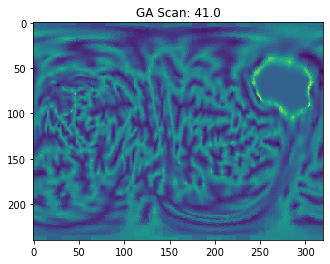

In [5]:
# you may need to edit these paths to match where the data is on your drive
directory = 'coursework1-data'  # we define the directory of the data
meta='Training_meta.pkl'
INDEX_EXAMPLE = 10


# ----------------------------------task 1.3 ------------------------------------
# get 1 example image from the dataset using idx=0 to get image and label, 
# ----------------------------------------------------------------------------

# Create dataset
dataset = Dataset2D(image_path=directory, meta_path=meta, label=LABEL_COLUMN_NAME)

# Print length
print(len(dataset))


# Get and print n-th image and label
exampleImage, exampleLabel = dataset[INDEX_EXAMPLE]
print(exampleImage.shape)

# Plot
plt.imshow(exampleImage[2,:,:])
plt.title('GA Scan: {}' .format(exampleLabel))


**Total Ex. 1: 10 marks**

## Exercise 2. Design Custom Augmentations

Now create custom transforms for your dataset. An example of a custom transform class for image resizing is given below. It includes an `__init__` constructor (which sets parameters) and a `__call__`  function (which takes as input data and performs a transformation) 

```
class ResizeImage(object):
    
       def __init__(self, image_size):
            self.image_size = image_size

       def __call__(self, data):
            if len(self.image_size) == 2:
                image_resized = resize(data, (self.image_size[0], self.image_size[1]),
                                       anti_aliasing=True)
            else:
                image_resized = resize(data, (self.image_size[0], self.image_size[1], self.image_size[2]),
                                       anti_aliasing=True)

            return image_resized
```
You may also want to reference the official [PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms)

#### Task 2.1 add a custom class for addition of Gaussian noise (3 marks)

- create a function which adds gaussian noise (with standard deviation controlled by input argument `gaus_noise`) to each data point in your image
- Note, although these are MRI metrics they are not directly derived from the MRI image intensities, thus Gaussian noise is a reasonable choice.


In [0]:
import random

class GaussianNoise:
    """
    GaussianNoise for adding Gaussian noise
        
    """
    
    def __init__(self, gaussianNoiseRange, debug=False):
        """input: 
           gauss_noise : standard deviation of noise
        """
        self.gaussianNoiseRange=gaussianNoiseRange
        self.debug = debug

    def __call__(self, image):
        # ------------------------------- task 2.1 -------------------------------------
        # augment image with random gaussian noise, where standard deviation of the noise is
        # determined by the self.gauss_noise parameter (expected 2-3 lines)
        # Perhaps the randomisation could have been done only use in the init function
        gaussianNoiseStandardDeviation = random.uniform(self.gaussianNoiseRange[0], self.gaussianNoiseRange[1]) # randomise each time
        noise = np.random.normal(0, gaussianNoiseStandardDeviation, image.shape)
        noisyImage = image + noise
        # ------------------------------------------------------------------
        if self.debug:
          return noisyImage, gaussianNoiseStandardDeviation # return the gaussian noise to see how they affect the image
        return noisyImage

#### Task 2.2 state what type of noise augmentation should be used for MRI image data and why (2 marks)

#### Answer:
Rician noise should be used for MR image data. 
This is because Rician distribution corresponds to a fourier transformed gaussian distribution and since MRI images are collected in the fourrier domain as spatial frequencies and are transformed to the image domain through the fourrier transform, Rician noise makes sense for MRI data.


#### Task 2.3 Using the functions imported from BsplineAugmentation.py, create a custom class to performing b-spline regularised elastic deformation (5 marks)

Note:
- imported module BsplineAugmentation contains a modified version of the Bspline augmentation code from Lecture 4 (which applies one 2D spline deformation to each channel of a multi-channel). It expects the channel dimension as the first axis
- the funcion `BsplineAugmentation.apply_elastic_deformation2D` includes an optional `debug` argument. You can use this to plot the deformed grid, which should help you test your function and choose appropriate parameters

What you need to do:
1. Edit  ` __init__` to pass the parameters of the elastic deformation. We have set the `debug` argument for you already. Use it to plot the deformation grid (only when set to `True`)
2. Create transform function `__call__` . Use above `GaussianNoise` function as a guide.


In [0]:
import random

# create a custom deformation augmentation class
class elastic_deform(object):
    """
    Elastically deform image
        
    """
    # design a class which returns an elastically deformed version of each image 
    # using tuning parameters sigma and num_controlpoints
         
    def __init__(self, numControlPointsrange, sigmaRange, debug=False):
        # ------------------------------- task 2.3.1 set parameters -------------------------------------
        self.numControlPointsrange = numControlPointsrange
        self.sigmaRange = sigmaRange
        # ------------------------------------------------------------------

        self.debug=debug

    def __call__(self, image):
      # ------------------------------- task 2.3.2 complete __call__ -------------------------------------
      # Perhaps the randomisation could have been done only use in the init function
      numControlPoints =  random.randint(self.numControlPointsrange[0], self.numControlPointsrange[1]) # randomise each time
      sigma = random.randint(self.sigmaRange[0], self.sigmaRange[1]) # randomise each time
      deformedImage = bspline.apply_elastic_deformation2D(image, numControlPoints, sigma, self.debug)
      if self.debug:
        return deformedImage, numControlPoints, sigma # return control points and sigma to see how they affect the image
      return deformedImage


#### Task 2.4 
- Test your custom transformations on the `example_im` you generated in 1.3. Plot the results for the third channel. (3 marks)

Marks assigned for:
- correctly instantiating an instance of each class (1 mark)
- correctly transforming the image using each transform (1 mark)
- correctly plotting (1 mark)

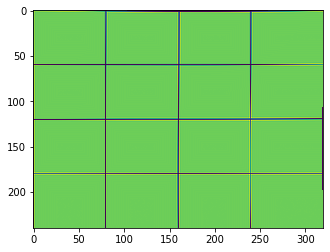

Text(0.5, 1.0, 'Elastic deformation with 3 control points and 1 sigma')

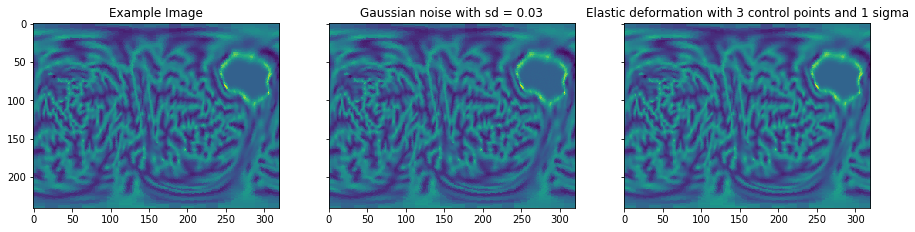

In [8]:
# ------------------------------- task 2.4 -------------------------------------
# test your transforms on an example image and print the results

# Create guassian noise image
gaussianNoise = GaussianNoise((0, 0.7), True) 
gaussianNoisyImage, noise = gaussianNoise(exampleImage) 

# Create elastic deformation image
elasticDeformation = elastic_deform((3, 7), (1, 3), True)
elasticDeformationImage, numControlPoints, sigma = elasticDeformation(exampleImage) 

# Start plotting
_, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,10))

# Plot the example image
axes[0].imshow(exampleImage[2,:,:])
axes[0].set_title('Example Image')

# Plot the gaussian noise image
axes[1].imshow(gaussianNoisyImage[2,:,:])
axes[1].set_title('Gaussian noise with sd = {}' .format(round(noise,2)))
# Plot the elastic transformation image
axes[2].imshow(elasticDeformationImage[2,:,:])
axes[2].set_title('Elastic deformation with {} control points and {} sigma' .format(numControlPoints, sigma))

#### Task 2.5 Suggest a suitable range for the parameters of each tranform. (3 marks)

#### Answer 2.5 
**Gaussian noise**

Gaussian range: Should be between 0 and 0.7. Higher than this means that some patterns in the image will be lost
<br>

**Elastic Deformation**

Control point range: Should be between 3 and 7. 
<br>
Sigma range: Should be between 1 and 3.

More than this deforms the features too much for them to be useful

#### Task 2.6 (Optionally) go back and edit your transforms so that they select parameters at random from this proposed range (4 marks) 

This will simulate a greater range of variability and allow the network to view the underformed original images.

However, the notebook will run ok without this, so consider going back and editting this at the end

**Total Ex. 2: 20 marks**

## Exercise 3: Create a training and validation DataLoaders

We will create separate training and validation Datasets and DataLoaders for our model. 

#### Task 3.1 Answer the following questions

A) What is the purpose of:
  - the training set?
  - the validation set?
  - the test set?

B) What would you say is happening if your network has low training error but high validation and test error?

C) What are the main difference between Training and Validation that need to be reflected in our sampling (i.e what do we do during trainng that would cause our validation set to change every time)?

(5 mark) 

**Answer** 
<br>A)

*   Training set: Samples used to create the model and adjust the weights of the network (used during training).
*   Validation set: Samples used mainly to reduce overfitting and to tune the hyper-parameters (used during training).
*   Test set: Samples used to measure the quality/performance of the final model by providing an unbiased evaluation.

<br>B) This probably means that it is overfitting.

<br>C) The main difference is that during validation we don't update the network's weights/parameters (i.e. no backward pass or optimiser updating) while during training we do both of those.


#### Task 3.2  create two new instance of your DataSet class. One for training and one for validation (6 marks)

**hint** You will need to use the `torchvision.transforms.Compose` function to create a single composed transform. 

We suggest setting the batch size of the validation loader to the total length of the validation set.


In [0]:
# ------------------------------- task 3.2 -------------------------------------
# compose transform
gaussianNoise = GaussianNoise((0, 0.7)) 
gaussianNoisyImage = gaussianNoise(exampleImage) 

# Create elastic deformation image
elasticDeformation = elastic_deform((3, 7), (1, 3))
elasticDeformationImage = elasticDeformation(exampleImage) 
composed= torchvision.transforms.Compose([gaussianNoise, elasticDeformation])
# ------------------------------------------------------------------

# ------------------------------- task 3.2 -------------------------------------
# create two new instances of the dataset Class  for training and validation
trainingDataset = Dataset2D(directory, meta, LABEL_COLUMN_NAME, composed)
validationDataset = Dataset2D(directory, meta, LABEL_COLUMN_NAME, composed)

# ------------------------------------------------------------------

#### Task 3.3. Now use this to create a DataLoader for train and validation data sets. 

**Note**, Train and validation splits are provided for you. You will need to:

1. Create two DataLoaders, one for training and one for validation (4 marks)
2. Return one batch of the `train_dataloader` by applying the next() function on the iterator, and plot the first example (1 marks)



(101,) 405
Batch length:  32
Training image shape:  torch.Size([3, 240, 320])


Text(0.5, 1.0, 'Training GA scan: 40.5')

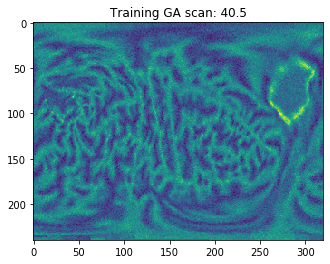

In [10]:
#### setting of parameters and selection of train and test set
trainingBatchSize = 32 

# training/ val split with SubsetRandomSampler (80%,20% split)
indices = list(range(len(trainingDataset)))  # start with all the indices in training set

# Get indices for train and validation datasets, and split the data
validation_idx = np.load('validation_idx.npy')
train_idx = list(set(indices) - set(validation_idx))
validationBatchSize = validation_idx.shape[0]

print(validation_idx.shape,len(train_idx))

# feed indices into the sampler
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# ------------------------------- task 3.3.1 -------------------------------------
# Create a dataloader for training and validation
# set batch_size for train to 32 and batch size for validation to equal the full number of validation examples
train_dataloader = torch.utils.data.DataLoader(trainingDataset, batch_size=trainingBatchSize, sampler=train_sampler)
val_dataloader = torch.utils.data.DataLoader(validationDataset, batch_size=validationBatchSize, sampler=train_sampler)


# ------------------------------- task 3.3.2 -------------------------------------
# return one batch and plot the first examples

#Training
trainingImageBatch, trainingLabelBatch = next(iter(train_dataloader))
print("Batch length: ", len(trainingImageBatch))
print("Training image shape: ", trainingImageBatch[0].shape)

plt.imshow(trainingImageBatch[0,2,:,:])
plt.title('Training GA scan: {}' .format(trainingLabelBatch[0]))

**Total Ex. 3: 15 marks**

## Exercise 4A - Create a ResNet

In the first instance we import the ResNet block function that you created in lecture 3. Complete the network constructor below such that it defines following layers:

1. Conv2d with 3 input channels, 16 output channels, kernel=3, stride=2, padding=1, bias=False
2. This is followed by a BatchNorm layer
3. resnet layer with 16 input channels, 32 output channels, two blocks and stride 2
4. resnet layer with 32 input channels, 64 output channels, two blocks and stride 2
5. resnet layer with 64 input channels, 96 output channels, two blocks and stride 2
6. A Fully connected linear layer with the number of input features equal to all activations in the previous output (**hint** you need to work out the spatial dimensions of the output of the final residual layer - this can be done on paper - or by debugging your network through training)

(13 marks)

Then put the layers together in the forward function. Add 
- ReLu activations where appropriate (**note** Relu is already defined for residual block layers). 
- Flattening prior to the linear layer 

(9 marks)

Use the Residual network we built in class to guide you. However, in this case, we do not recommend an average pool prior to the linear layer for this network. In our experiments, it downgraded performance.


In [0]:
from ResidualBlock import ResidualBlock 
    
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels, FC_channels,num_classes=1):
        '''
        Constructor input:
            block: instance of residual block class
            num_blocks: how many layers per block (used in _make_layer)
            num_strides: list with number of strides for each layer (see Lecture 3)
            num_features: list with number of features for each layer
            FC_Channels: number of inputs expected for the fully connected layer (must
                        equal the total number of activations returned from preceding layer)
            num_classes: (number of outputs of final layer)
        '''
        super(ResNet, self).__init__()
        self.in_planes = 16
        # ------------------------------ task 4A -------------------------------
        # complete convolutional and linear layers (6 lines)
        self.conv1 = nn.Conv2d(in_channels, num_features[0], kernel_size=(3,3), stride=num_strides[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features[0])
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.linear = nn.Linear(in_features=FC_channels, out_features=num_classes)
        
        # ----------------------------------------------------------------------

    def _make_layer(self, block, planes, num_blocks, stride):
        '''
        This creates each residual layer by stacking residual blocks
        '''
        layers = []
        
        for i in np.arange(num_blocks -1):
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes 
        
        layers.append(block(planes, planes, stride))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        # ------------------------------ task 2 -------------------------------
        # complete the forward pass
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)

        out = self.layer2(out)

        out = self.layer3(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
        # ---------------------------------------------------------------------


## Exercise 4B - Choose an optimiser and loss function; load network to device

Initialise your network and create an optimiser and a loss function for your network. We create an Adam optimiser for you as it trains fastest (although you are welcome to use something else). We also propose a suitable starting learning rate.

1. Set the device to GPU (make sure you have set your Colab enviroment to run on GPU or this will take too long to train)
2. Create (Instantiate) an instance of your network model class (we initialise and load it to the device for you)
3. Create a suitable loss as the variable `criterion`

(5 marks)


In [0]:
lr = 0.001
betas = (0.5, 0.999)
numStrides = [2, 2, 2, 2]
numFeatures = [16, 32, 64, 96]
inChannels = 3
fcChannels = 96 * 20 * 15 # Divide 2nd and 3rd dimension by 6
numClasses = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

net = ResNet(block=ResidualBlock, num_blocks=2, num_strides=numStrides, num_features=numFeatures, in_channels=inChannels, FC_channels=fcChannels, num_classes=numClasses)

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, betas=betas)
criterion  = nn.MSELoss()
# criterion = criterion.to(device)

net.apply(weights_init)
net = net.to(device)

#### Task 4B.5  Explain why the Adam optimiser speeds up training. State the possible limitations of Adam and propose a way of adressing this. (3 marks)

#### Answer
Adam speeds up training by using momentum. Momentum allows the use of higher learning rates which reduce training time.
<br>
In some cases Adam fails to converge to the optimum solution possibly because of the exponential moving average. 
<br>
One way to address this is to combine/use an ensemble of optimisers. For example, we can use Stochastic Gradient Descent towards the end of the training.

**Total Ex. 4: 30 marks**

## Exercise 5: Train your network

Complete the below code to correctly train and validate your ResNet function. 
1. Don't forget to set your network to `train` or `eval` mode before training and validation loops respectively (you don't want your network to be updating parameters during evaluation) (2 marks)
2. complete the training loop in order to perform forward and backwards pass. (5 marks)
    - Print the loss at each iteration
3.  perform a forward pass for each validation loop. (3 marks)
    - Save the mean error over all valisation examples for each loop 
    - use this to return the best performance of the model at the end.

We've set it to train for 10 epochs but you may want to use less when debugging and more once you're sure it's right. We've also provided code for plotting the validation prediction against the true labels to help your visualise your training. It expects the output of the __validation__ pass through the network to be saved to variable x_out.

(10 marks)

**hints**
- see Lectures 2 and 3 for examples of training and validation loops
- don't forget you need to load data to the GPU memory (i.e. the device)
- you will need to run `x_out = x_out.squeeze(1)` for `x_out = net(data)` (the output of your forward pass) - we add this for you for the training loop - don't forget to implelment it for validation.

[1,     1] loss: 1661.604
[1,    11] loss: 3.387
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


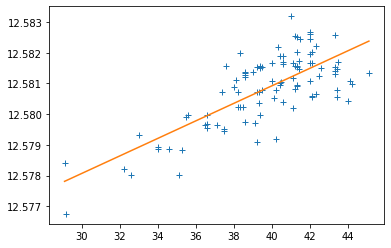

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


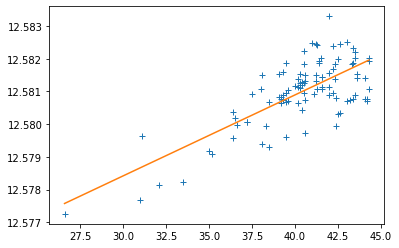

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


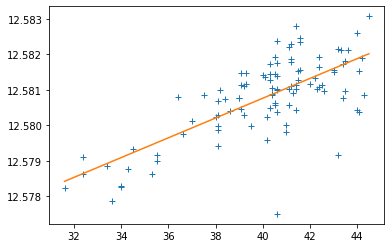

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


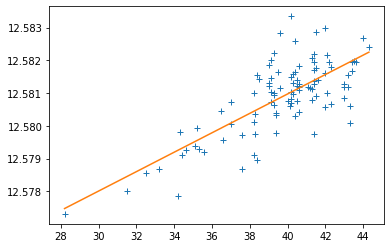

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


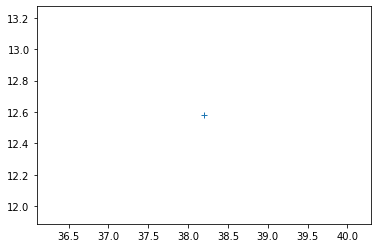

[2,     1] loss: 1.726
[2,    11] loss: 7.013
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


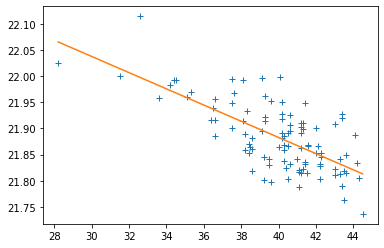

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


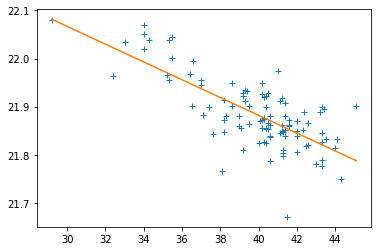

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


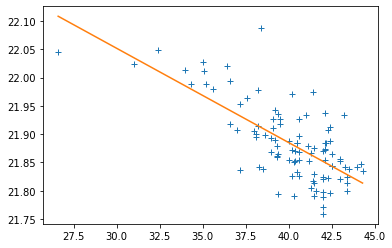

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


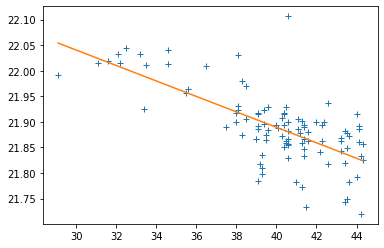

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


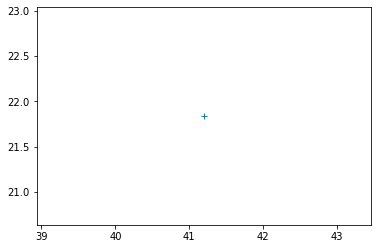

[3,     1] loss: 3.917
[3,    11] loss: 5.463
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


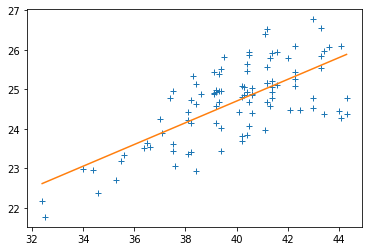

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


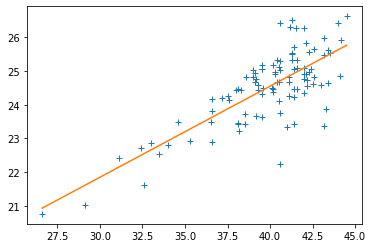

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


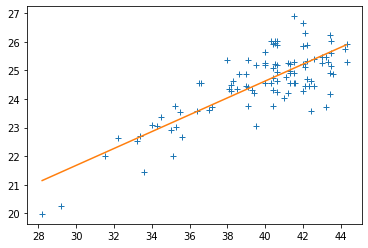

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


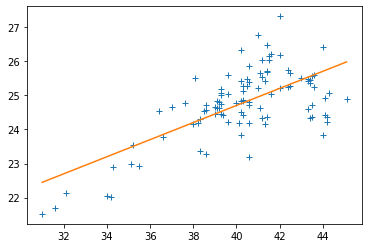

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


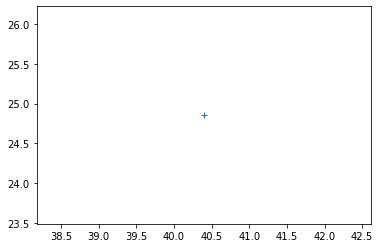

[4,     1] loss: 7.433
[4,    11] loss: 2.178
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


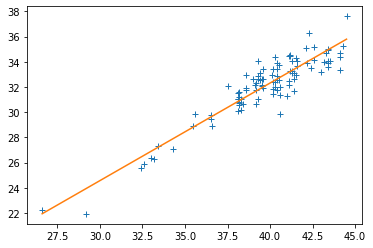

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


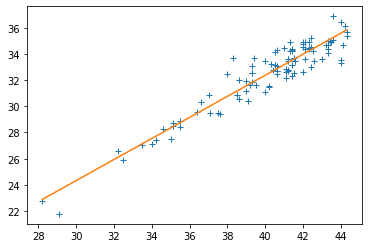

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


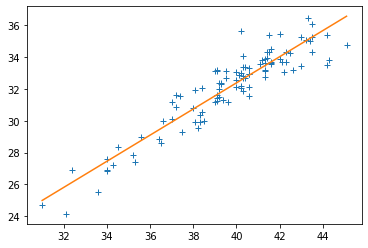

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


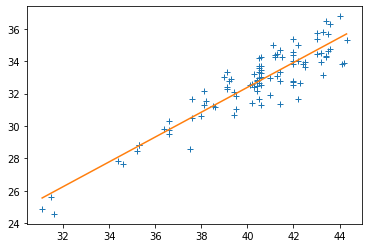

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


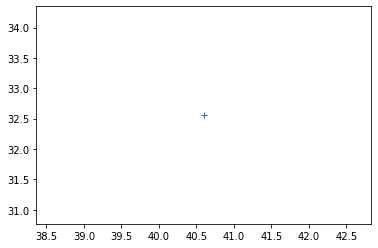

[5,     1] loss: 8.261
[5,    11] loss: 1.761
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


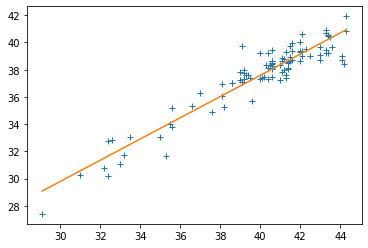

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


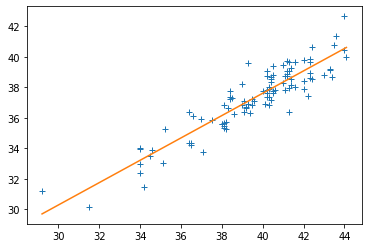

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


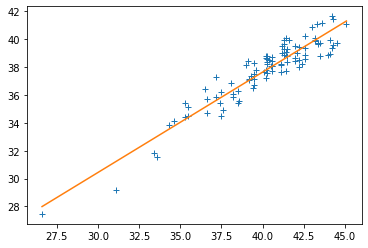

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


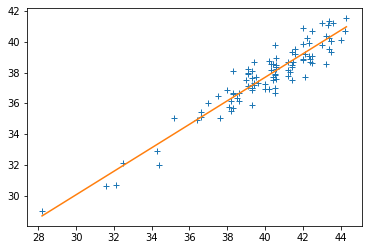

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


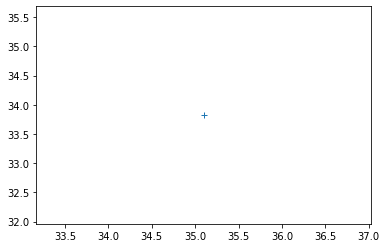

[6,     1] loss: 3.365
[6,    11] loss: 1.533
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


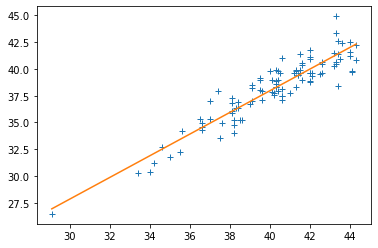

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


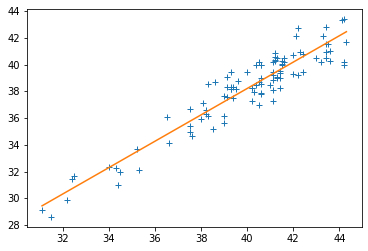

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


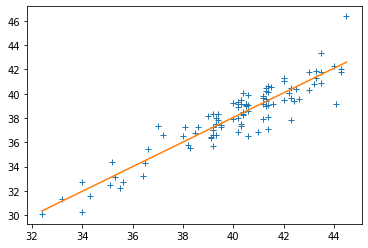

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


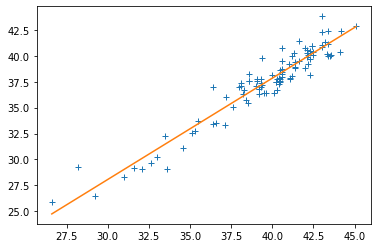

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


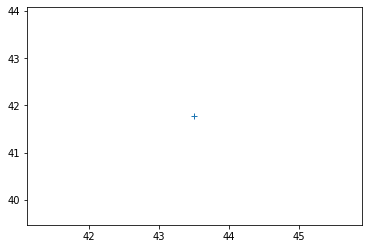

[7,     1] loss: 3.479
[7,    11] loss: 1.548
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


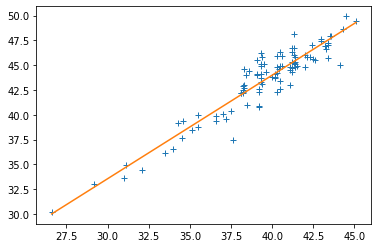

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


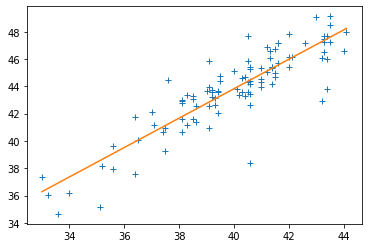

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


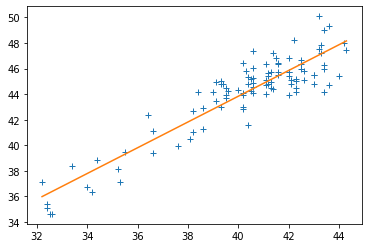

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


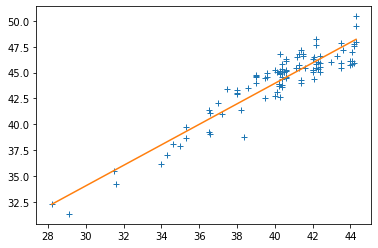

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


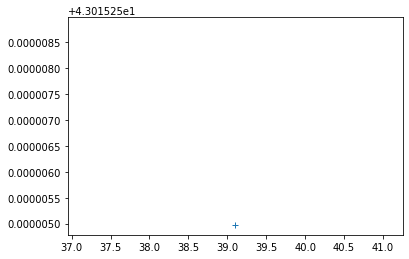

[8,     1] loss: 1.820
[8,    11] loss: 8.708
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


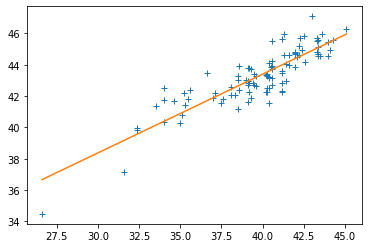

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


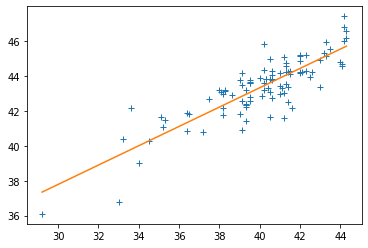

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


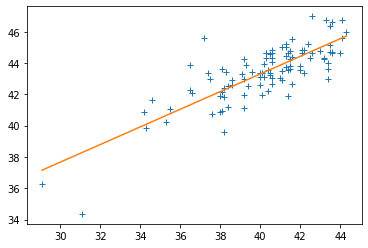

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


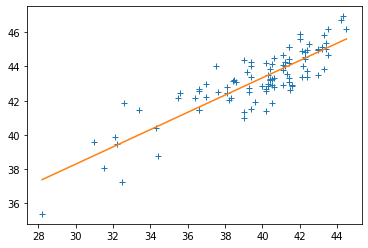

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


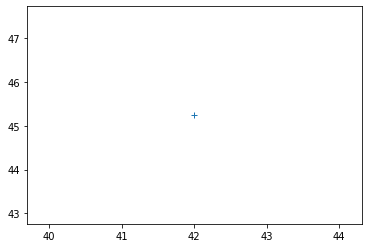

[9,     1] loss: 2.364
[9,    11] loss: 2.453
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


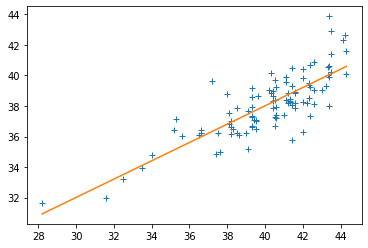

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


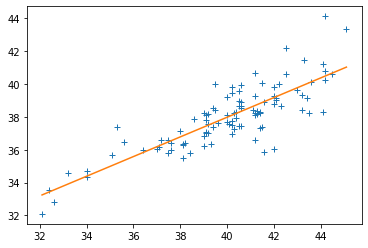

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


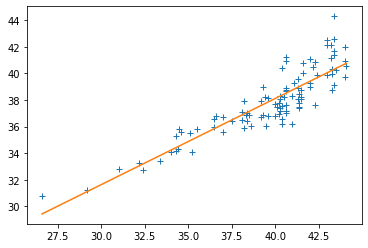

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


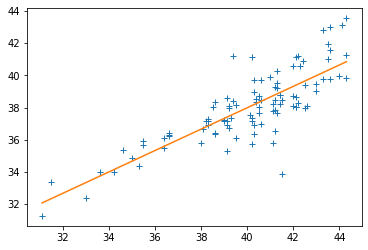

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


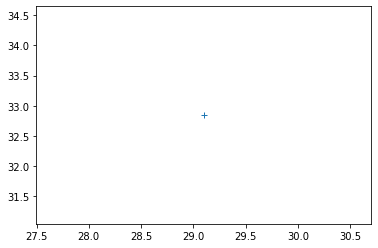

[10,     1] loss: 4.733
[10,    11] loss: 8.438
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


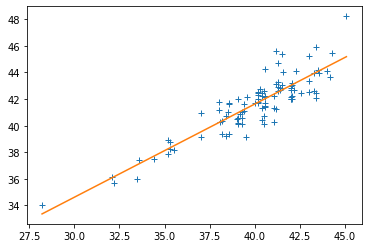

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


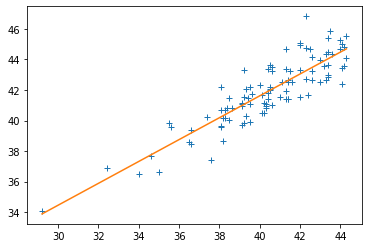

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


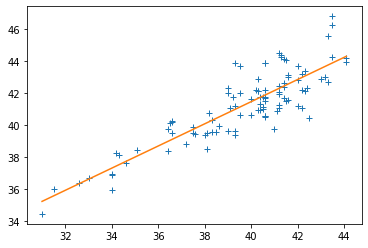

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


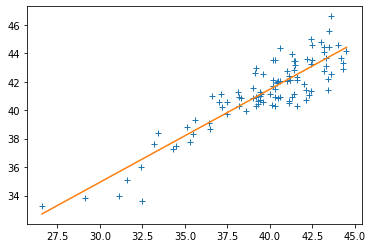

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


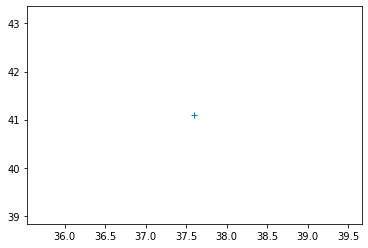

[11,     1] loss: 1.439
[11,    11] loss: 11.627
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


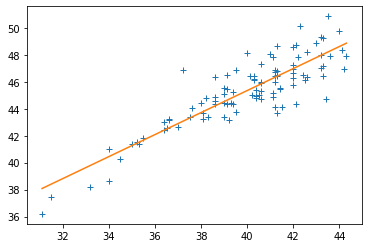

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


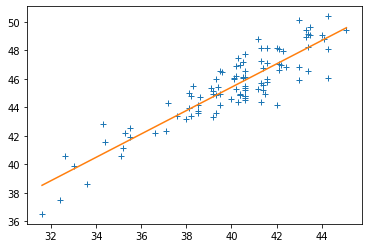

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


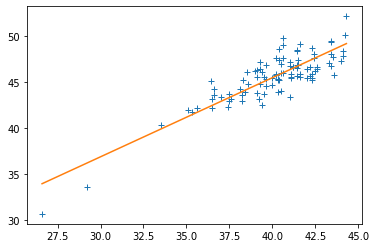

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


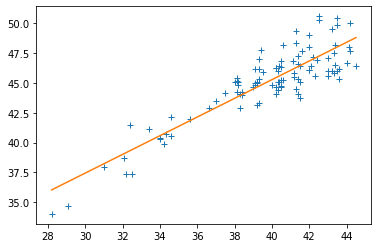

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


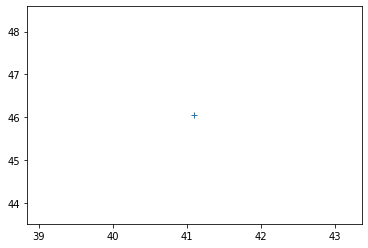

[12,     1] loss: 7.264
[12,    11] loss: 2.312
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


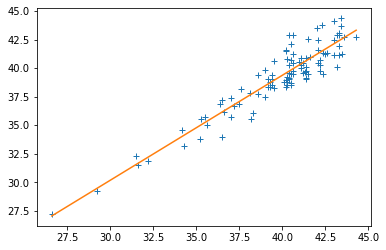

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


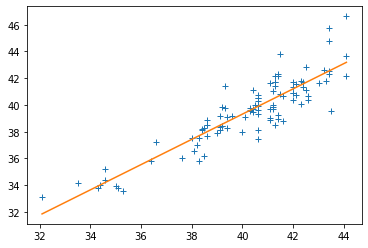

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


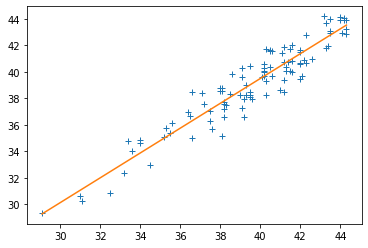

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


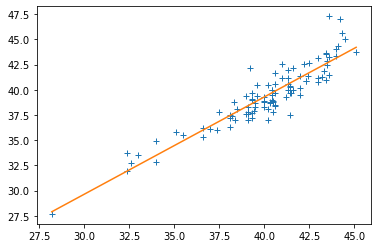

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


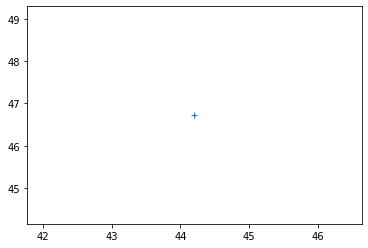

[13,     1] loss: 3.570
[13,    11] loss: 1.819
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


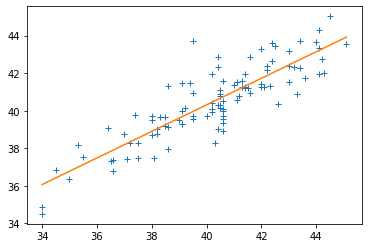

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


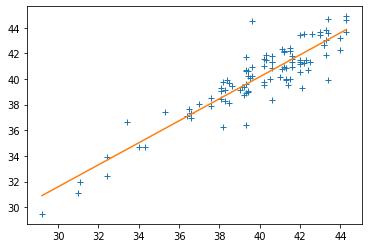

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


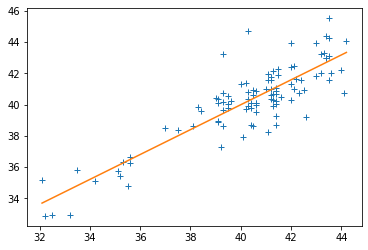

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


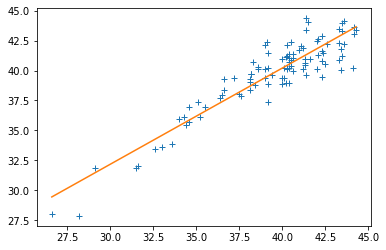

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


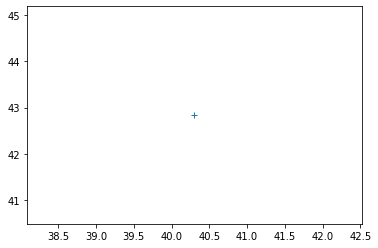

[14,     1] loss: 1.866
[14,    11] loss: 18.440
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


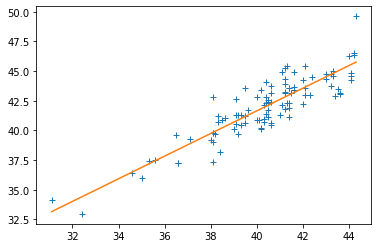

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


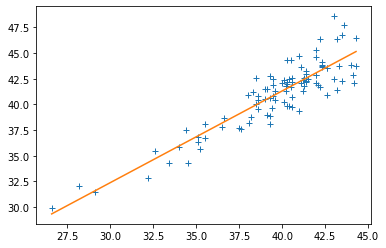

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


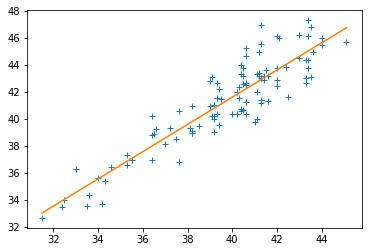

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


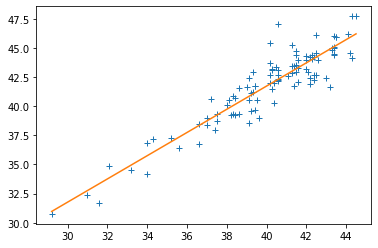

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


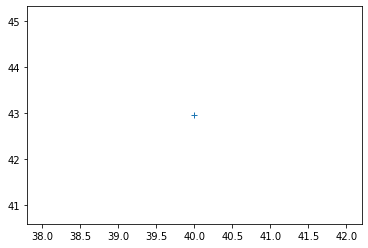

[15,     1] loss: 3.255
[15,    11] loss: 14.277
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


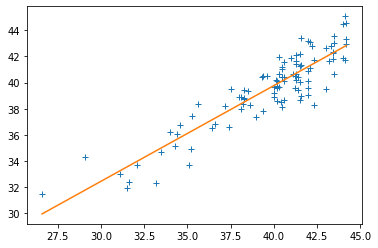

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


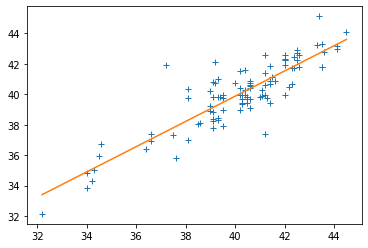

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


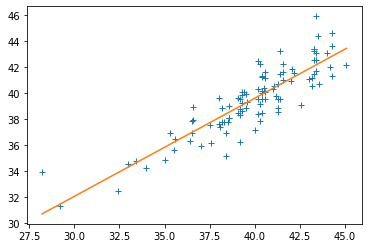

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


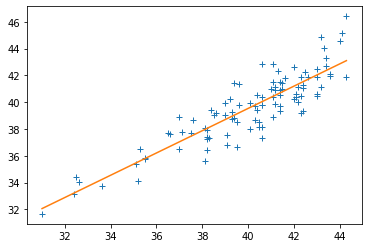

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


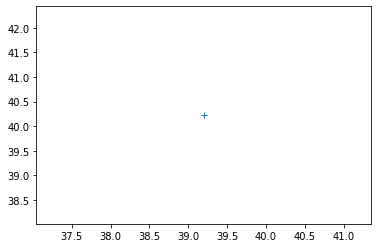

[16,     1] loss: 11.492
[16,    11] loss: 0.938
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


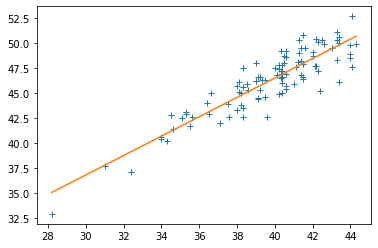

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


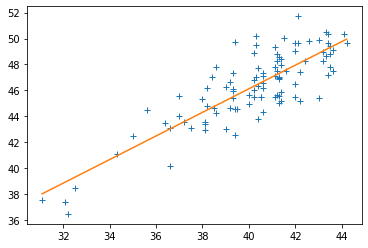

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


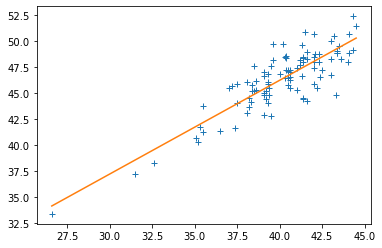

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


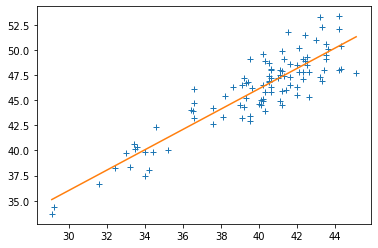

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


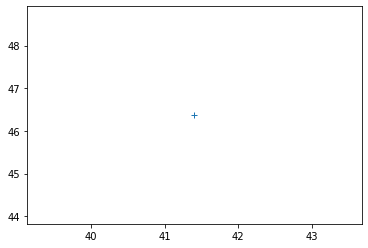

[17,     1] loss: 4.109
[17,    11] loss: 1.008
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


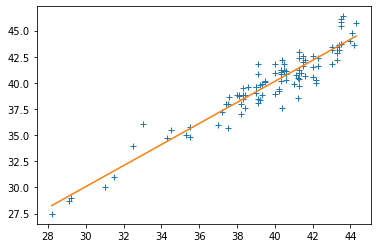

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


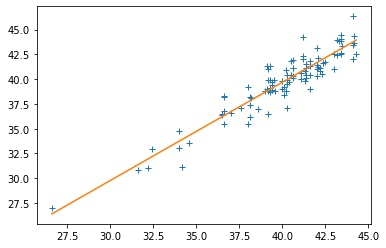

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


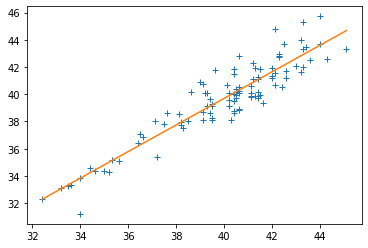

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


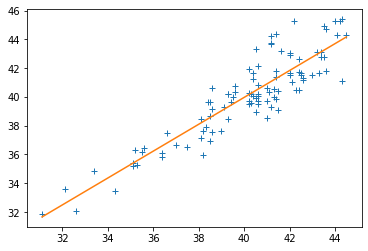

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


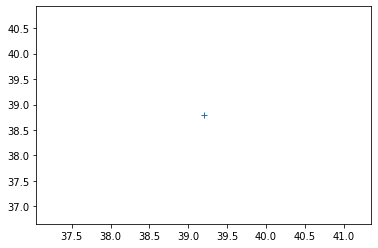

[18,     1] loss: 1.501
[18,    11] loss: 5.944
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


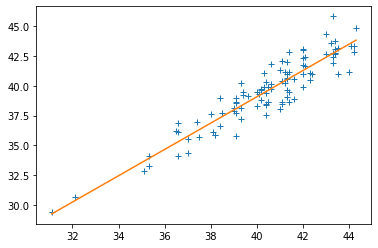

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


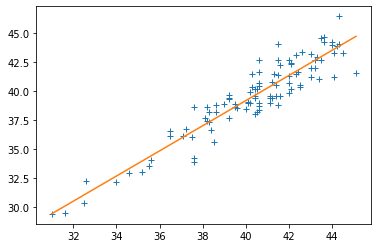

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


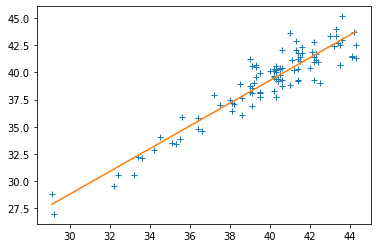

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


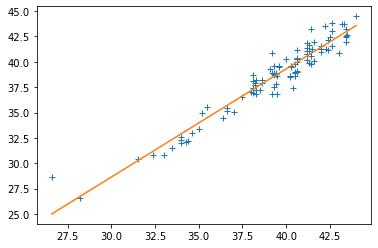

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


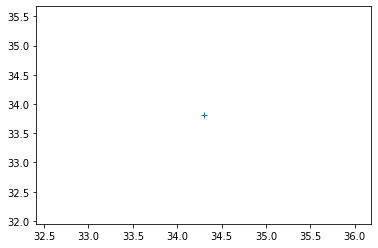

[19,     1] loss: 1.446
[19,    11] loss: 8.841
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


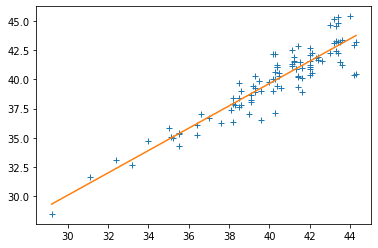

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


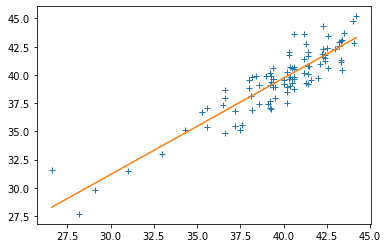

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


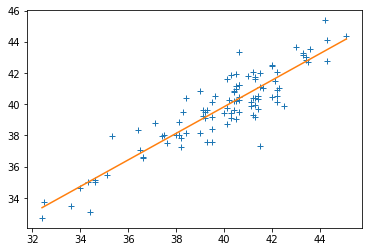

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


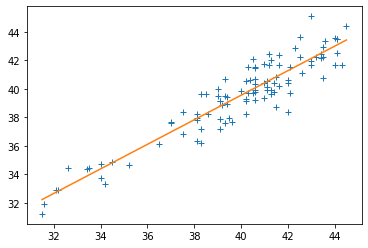

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


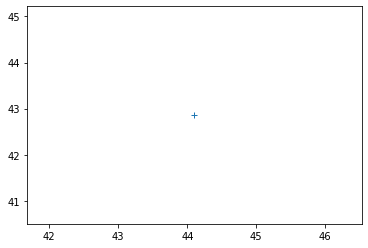

[20,     1] loss: 4.046
[20,    11] loss: 2.488
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


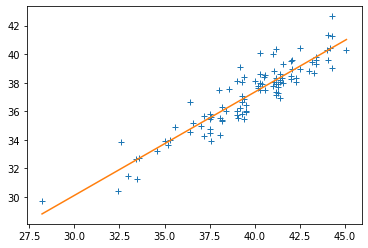

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


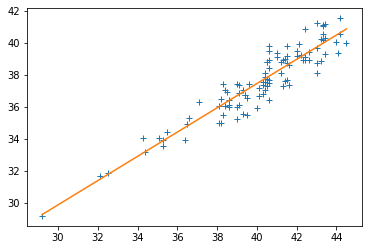

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


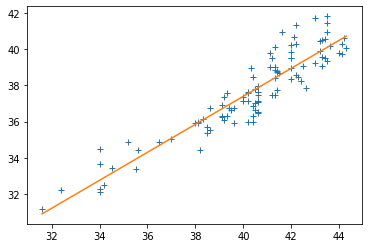

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


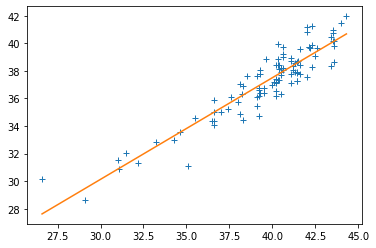

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


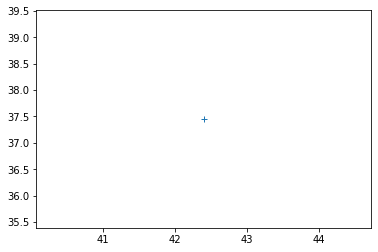

[21,     1] loss: 4.177
[21,    11] loss: 11.761
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


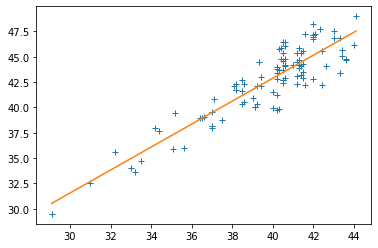

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


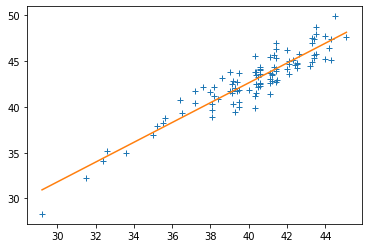

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


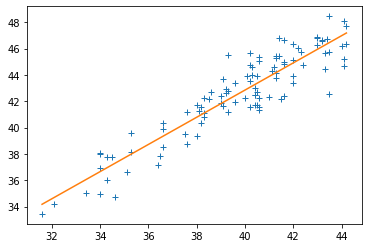

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


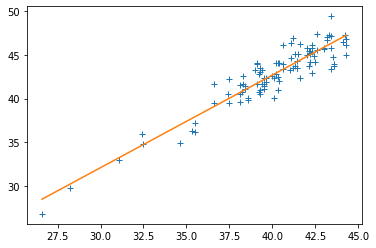

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


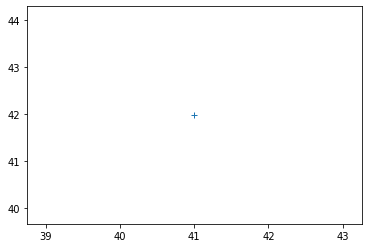

[22,     1] loss: 1.593
[22,    11] loss: 0.820
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


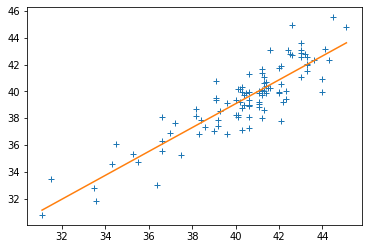

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


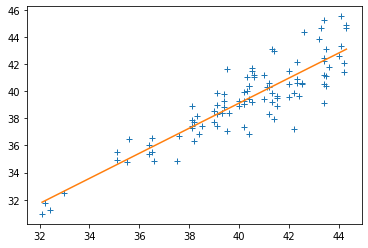

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


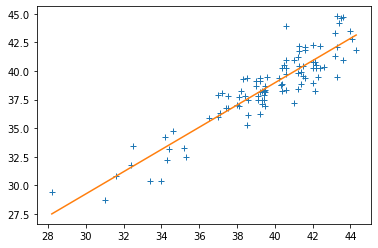

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


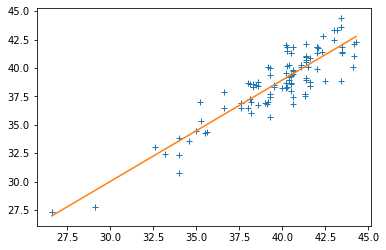

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


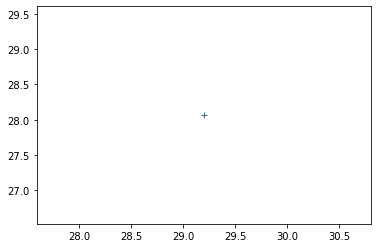

[23,     1] loss: 5.728
[23,    11] loss: 1.347
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


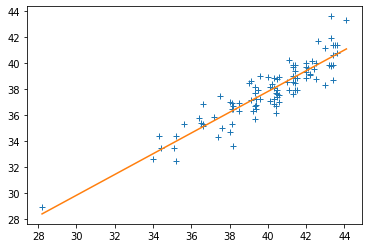

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


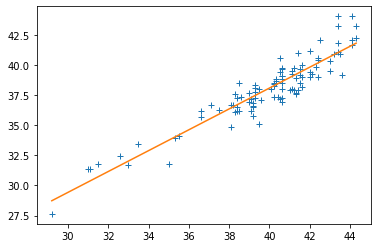

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


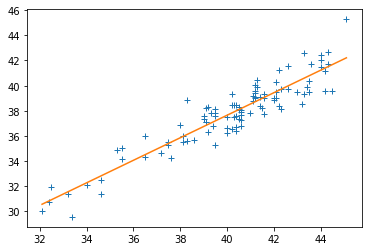

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


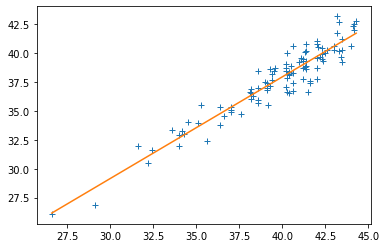

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


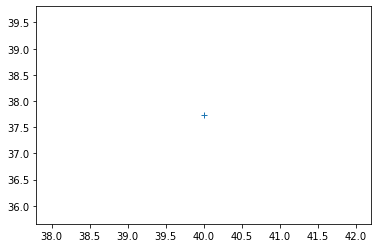

[24,     1] loss: 1.840
[24,    11] loss: 0.607
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


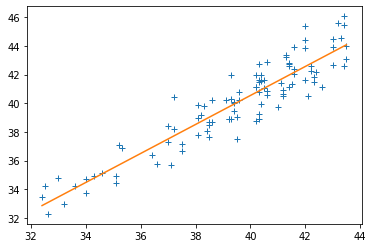

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


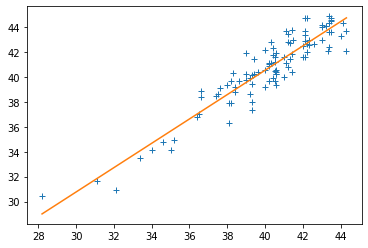

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


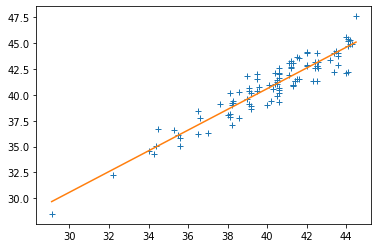

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


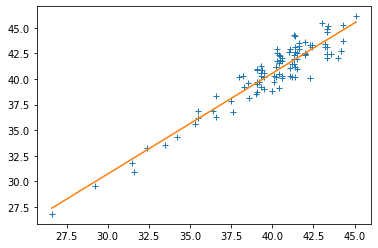

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


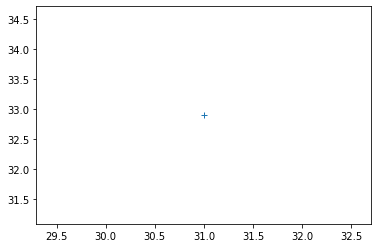

[25,     1] loss: 1.564
[25,    11] loss: 3.927
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


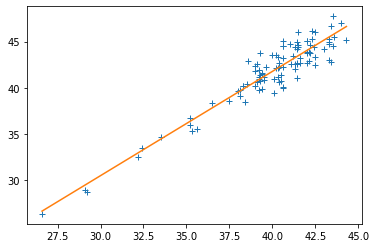

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


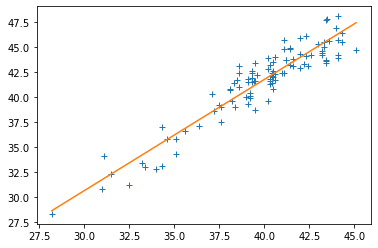

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


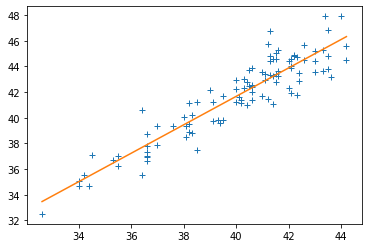

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


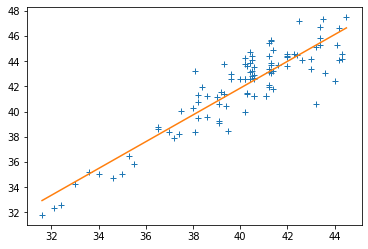

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


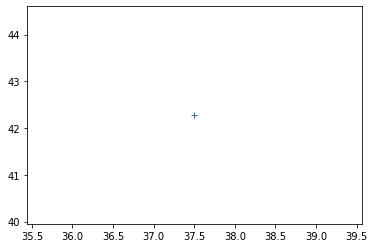

[26,     1] loss: 1.623
[26,    11] loss: 12.322
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


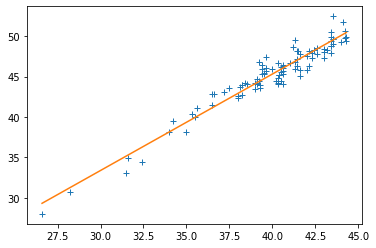

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


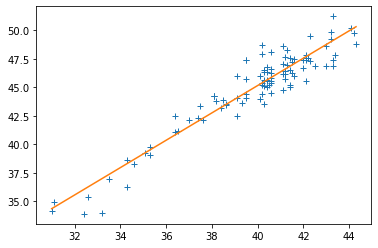

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


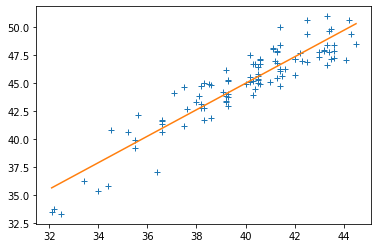

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


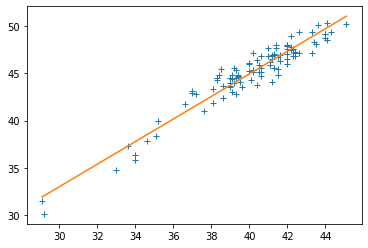

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


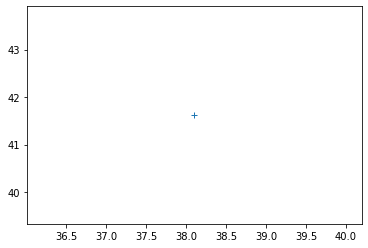

[27,     1] loss: 7.101
[27,    11] loss: 7.339
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


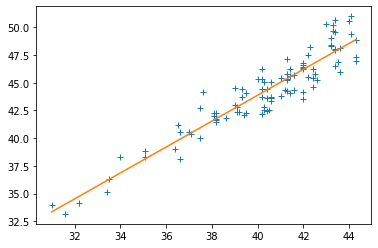

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


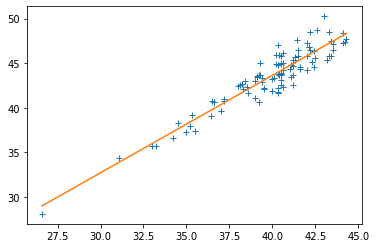

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


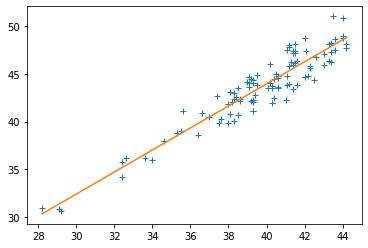

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


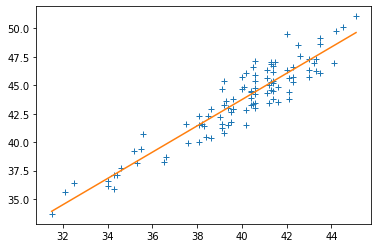

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


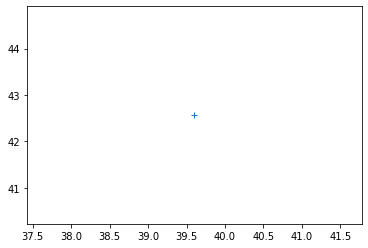

[28,     1] loss: 3.412
[28,    11] loss: 5.947
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


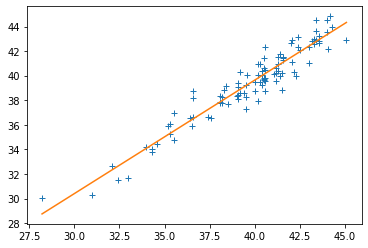

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


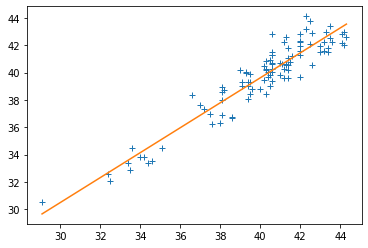

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


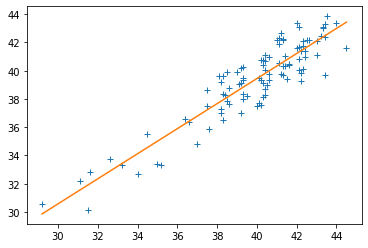

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


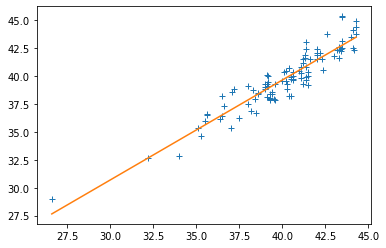

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


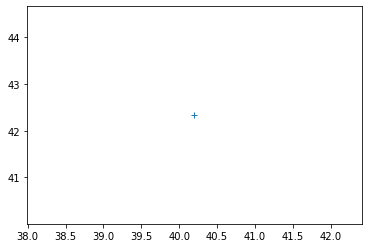

[29,     1] loss: 0.899
[29,    11] loss: 3.421
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


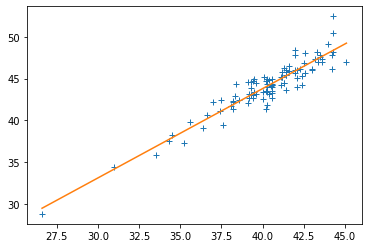

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


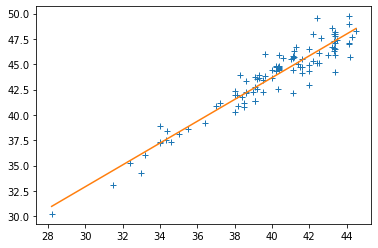

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


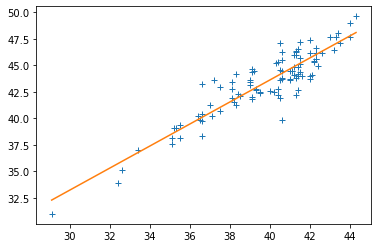

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


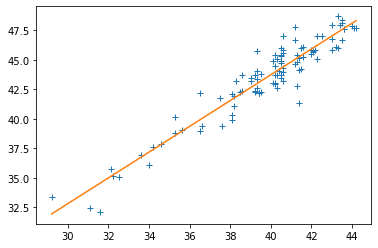

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


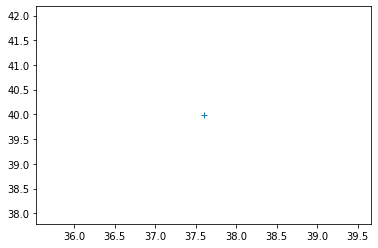

[30,     1] loss: 5.634
[30,    11] loss: 4.266
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


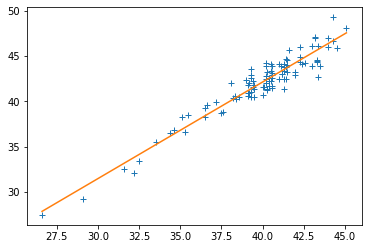

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


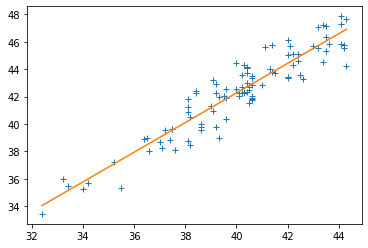

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


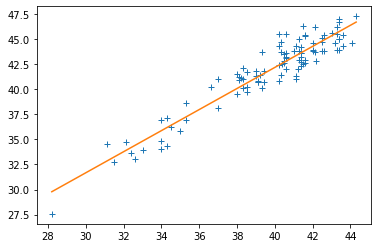

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


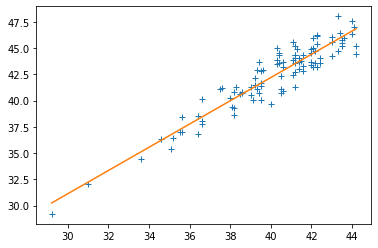

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


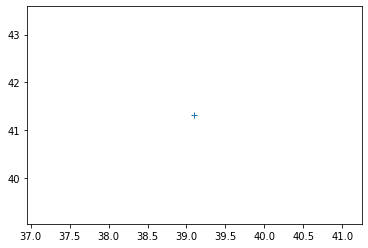

[31,     1] loss: 5.111
[31,    11] loss: 1.032
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


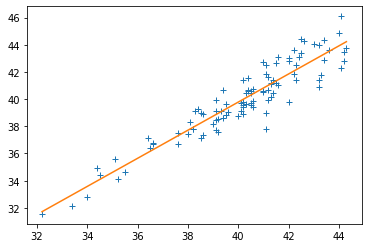

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


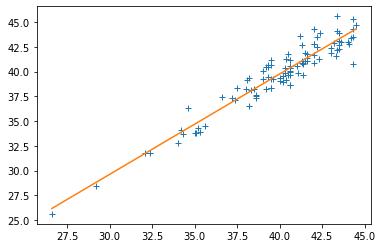

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


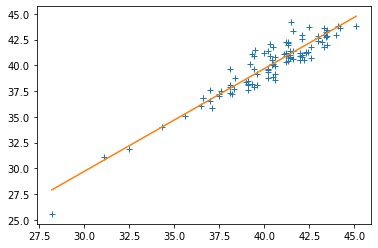

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


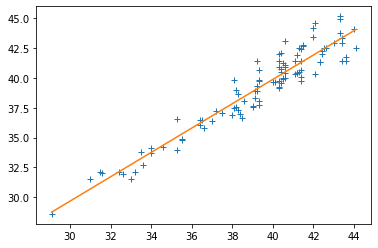

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


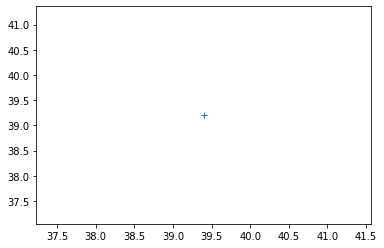

[32,     1] loss: 5.326
[32,    11] loss: 4.418
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


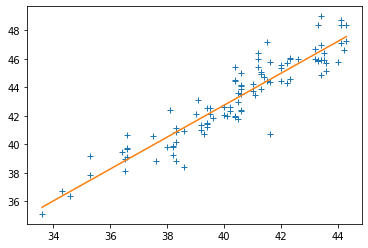

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


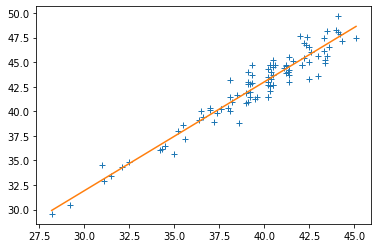

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


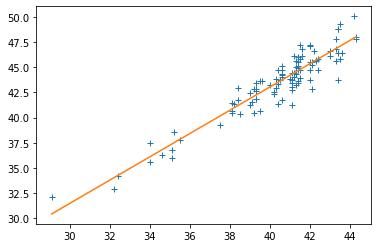

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


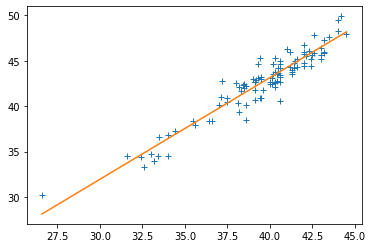

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


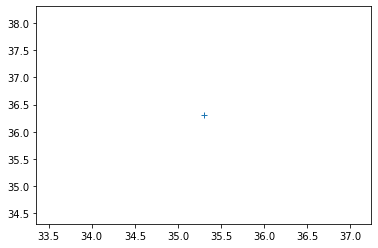

[33,     1] loss: 5.139
[33,    11] loss: 0.841
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


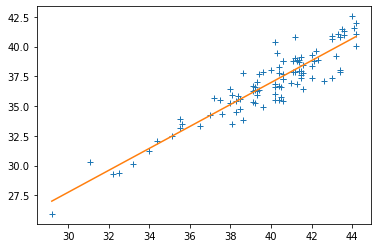

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


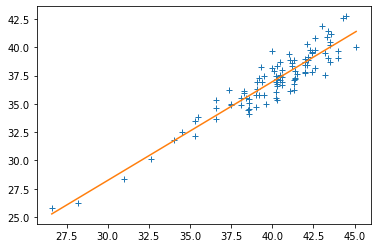

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


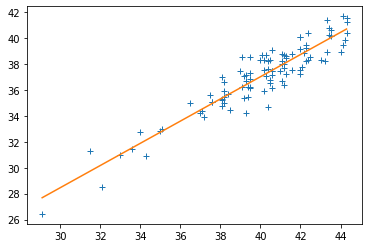

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


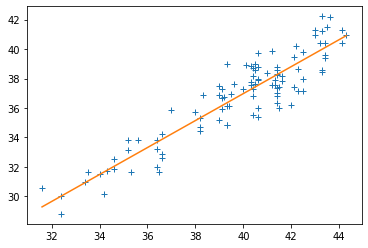

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


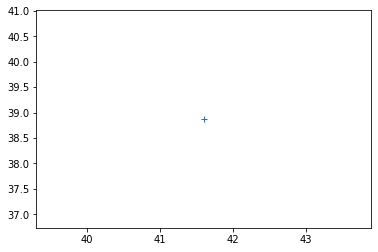

[34,     1] loss: 22.302
[34,    11] loss: 2.803
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


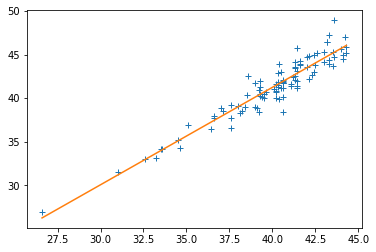

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


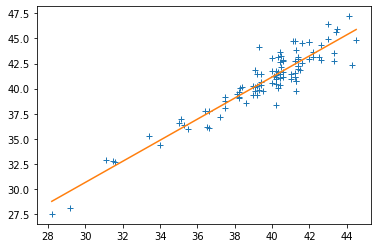

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


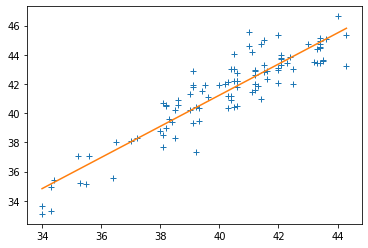

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


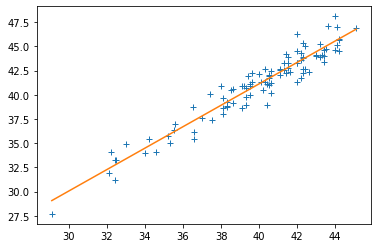

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


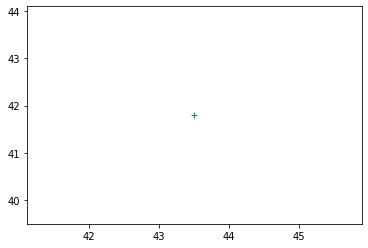

[35,     1] loss: 1.459
[35,    11] loss: 1.050
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


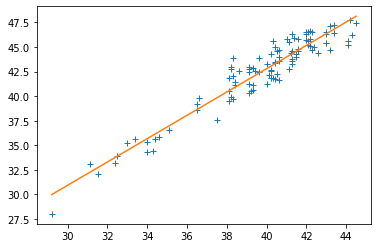

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


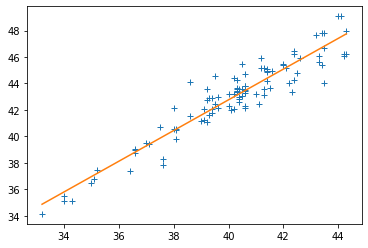

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


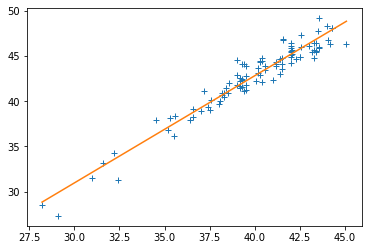

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


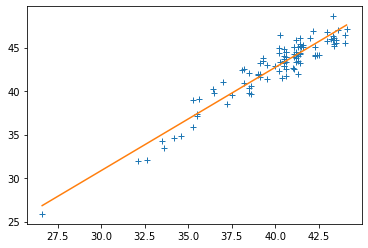

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


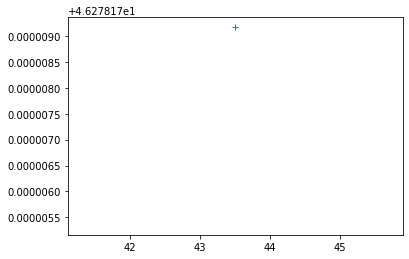

[36,     1] loss: 2.225
[36,    11] loss: 0.721
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


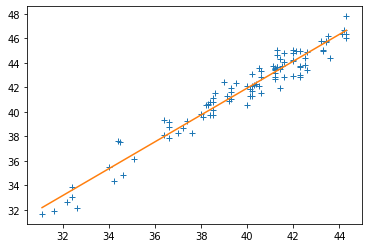

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


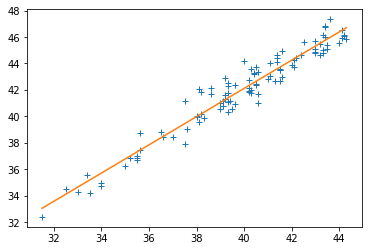

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


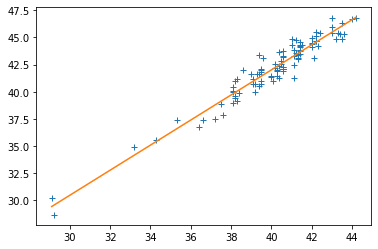

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


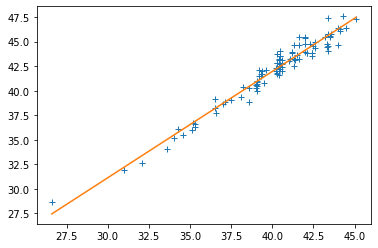

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


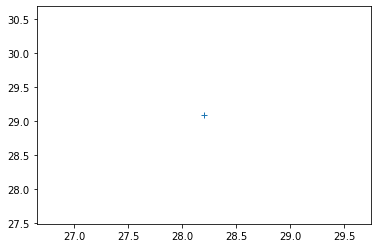

[37,     1] loss: 0.661
[37,    11] loss: 2.604
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


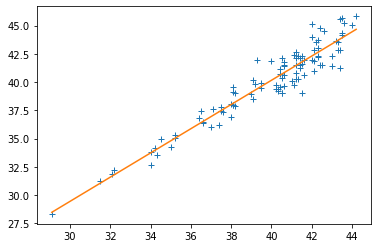

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


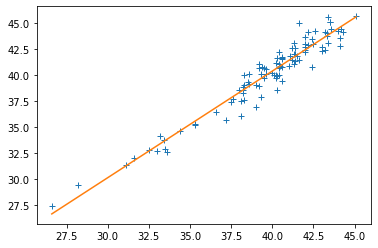

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


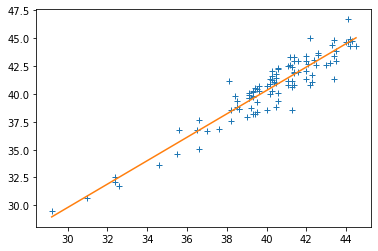

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


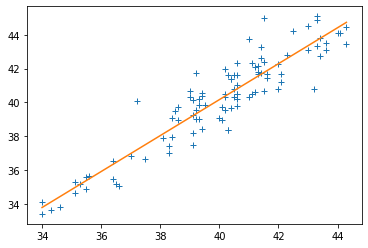

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


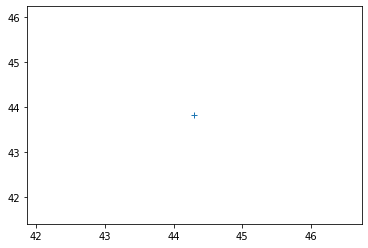

[38,     1] loss: 4.663
[38,    11] loss: 5.214
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


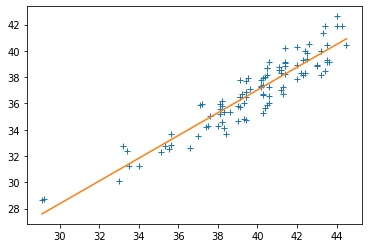

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


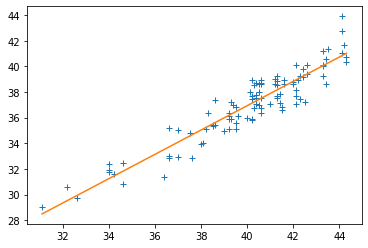

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


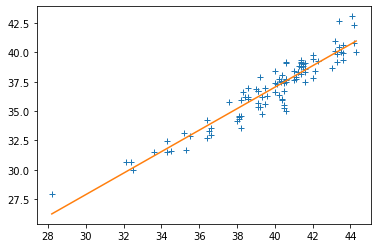

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


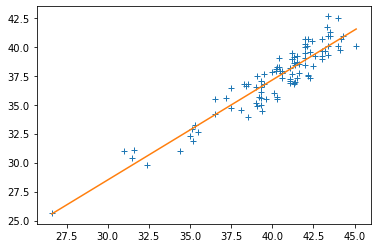

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


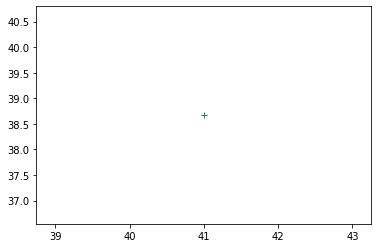

[39,     1] loss: 4.584
[39,    11] loss: 1.571
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


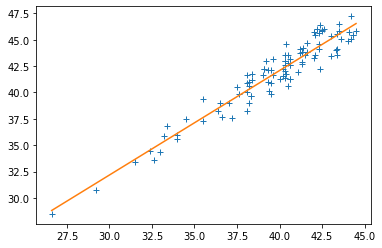

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


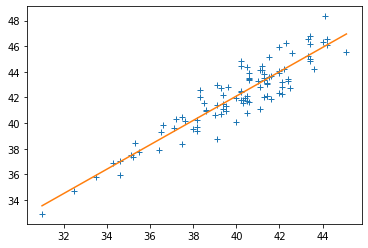

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


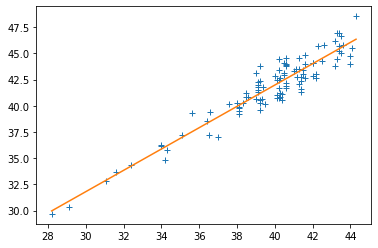

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


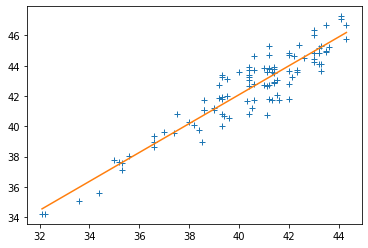

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


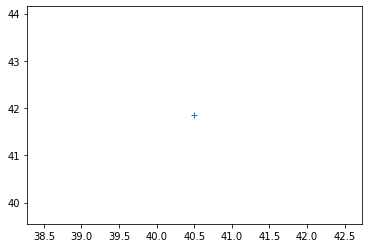

[40,     1] loss: 4.849
[40,    11] loss: 4.010
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


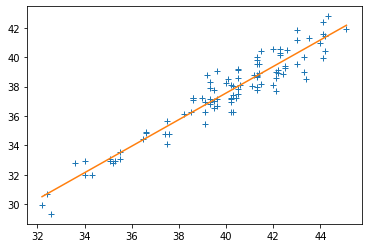

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


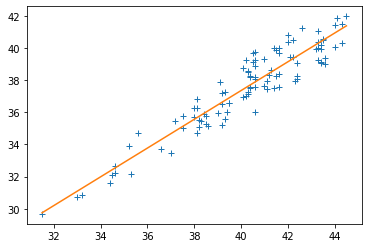

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


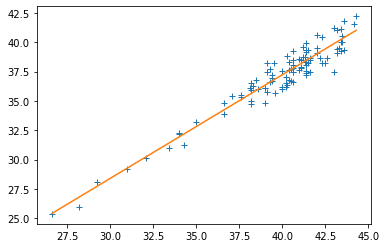

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


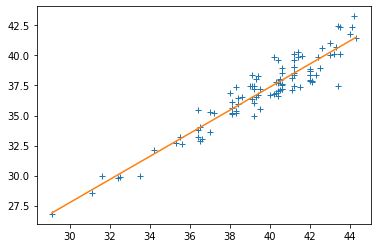

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


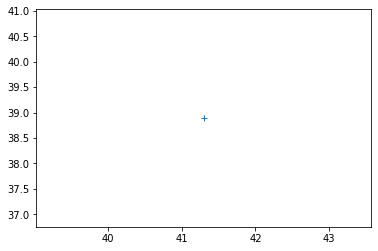

[41,     1] loss: 1.272
[41,    11] loss: 1.892
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


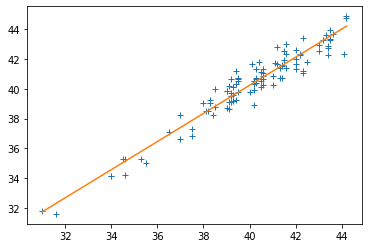

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


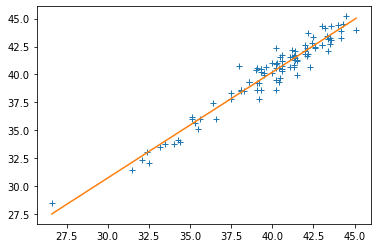

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


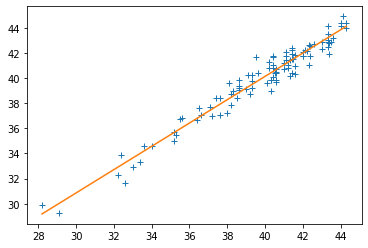

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


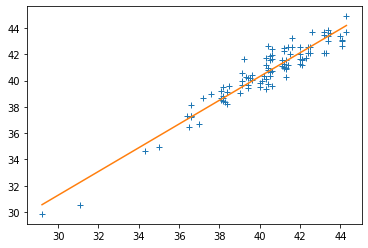

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


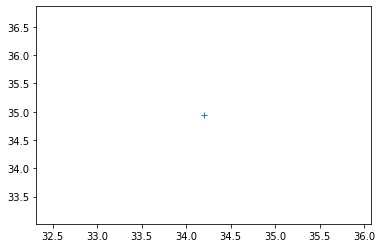

[42,     1] loss: 1.068
[42,    11] loss: 0.649
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


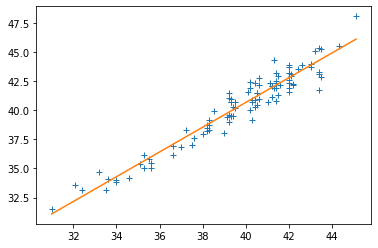

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


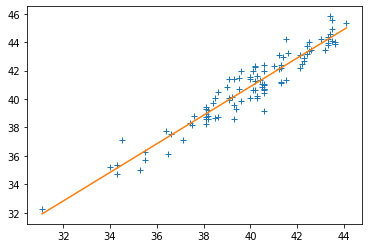

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


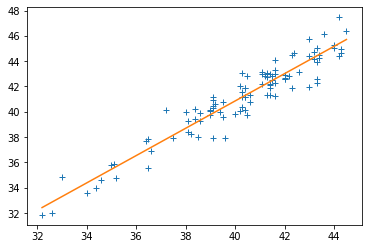

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


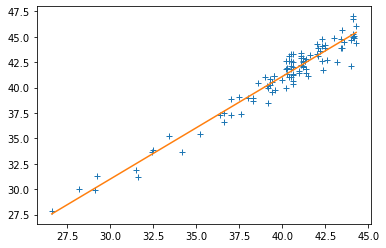

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


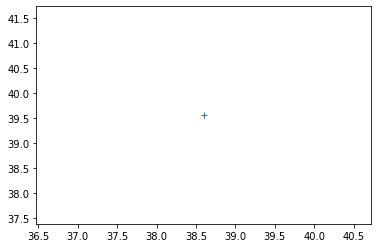

[43,     1] loss: 4.134
[43,    11] loss: 6.049
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


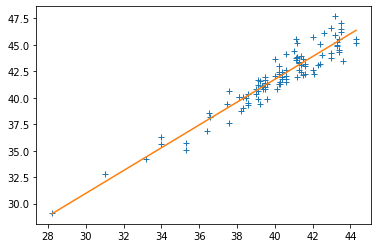

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


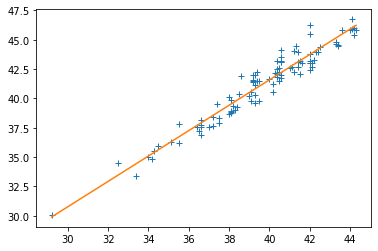

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


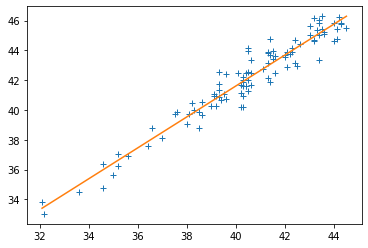

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


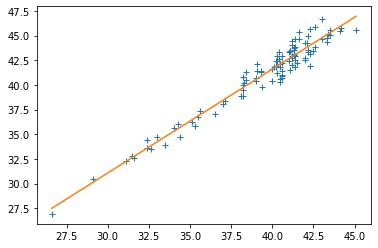

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


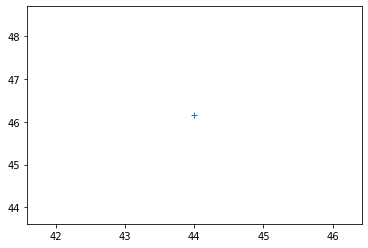

[44,     1] loss: 1.494
[44,    11] loss: 1.160
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


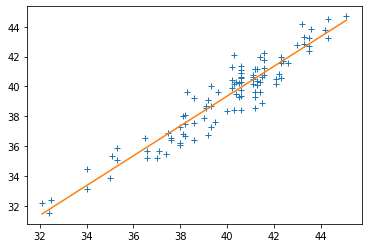

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


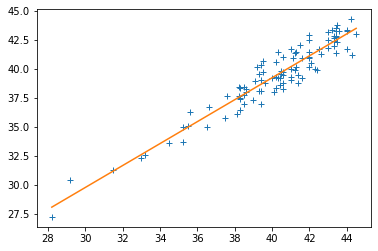

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


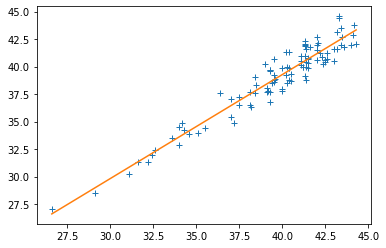

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


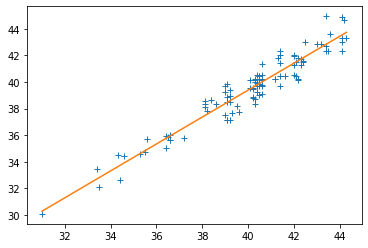

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


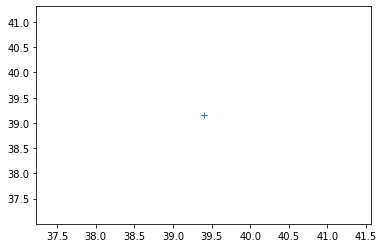

[45,     1] loss: 7.587
[45,    11] loss: 0.793
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


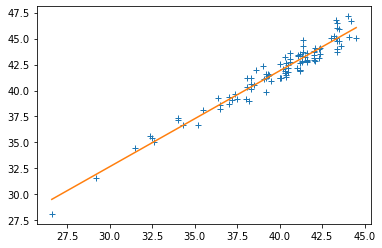

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


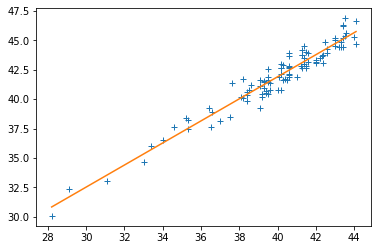

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


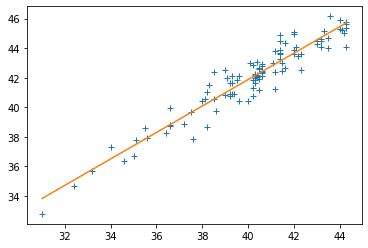

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


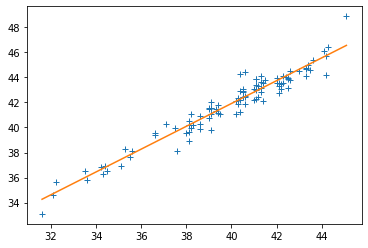

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


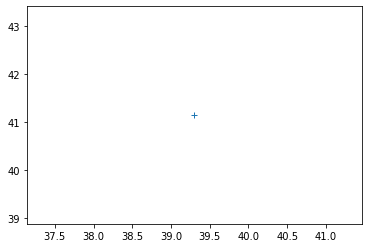

[46,     1] loss: 2.786
[46,    11] loss: 0.485
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


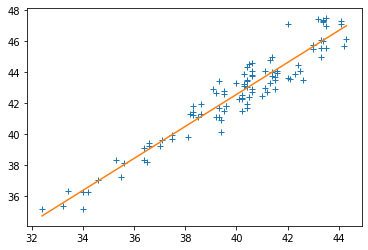

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


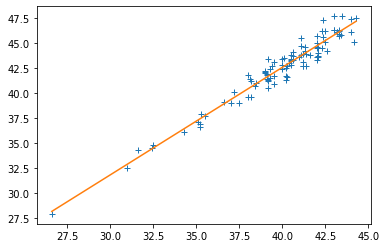

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


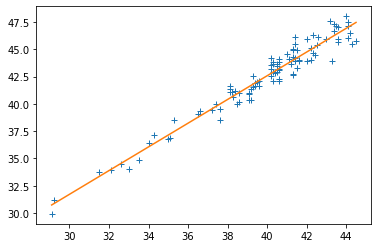

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


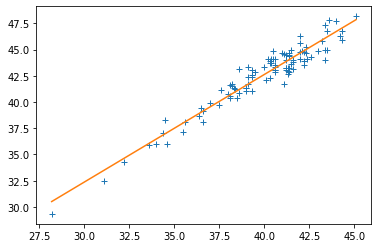

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


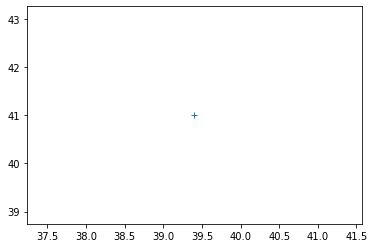

[47,     1] loss: 9.429
[47,    11] loss: 5.390
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


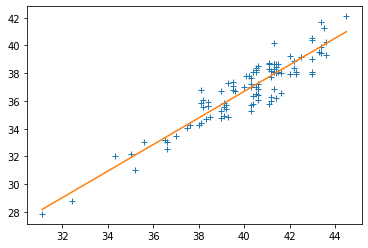

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


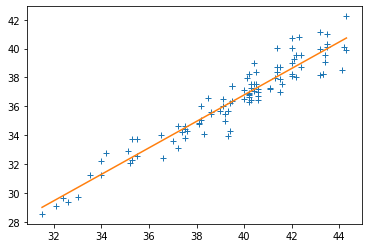

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


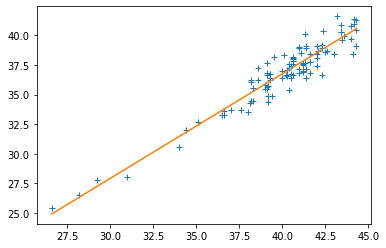

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


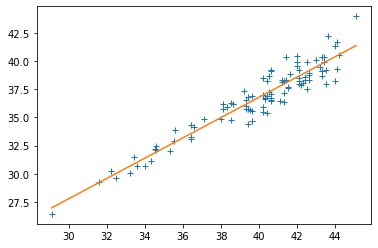

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


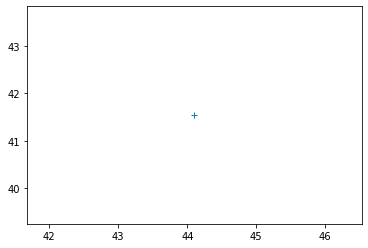

[48,     1] loss: 7.498
[48,    11] loss: 1.834
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


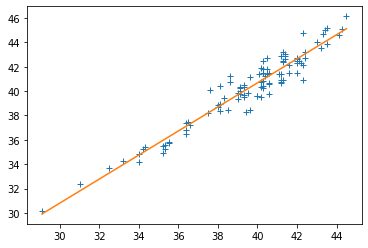

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


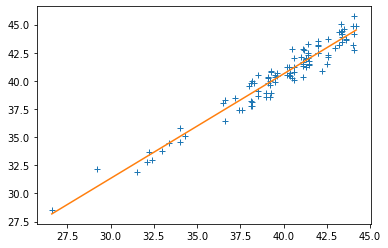

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


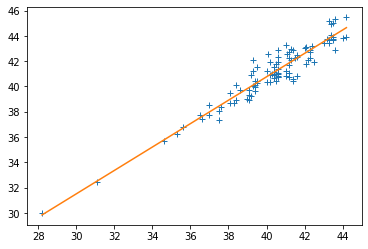

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


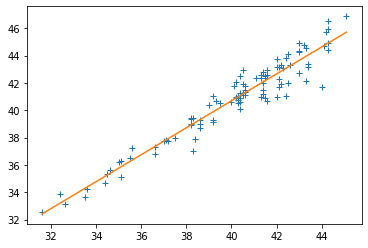

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


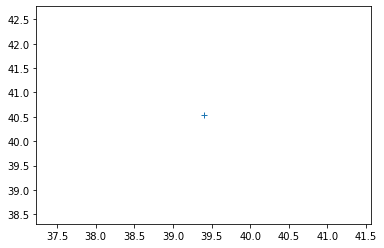

[49,     1] loss: 0.805
[49,    11] loss: 1.768
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


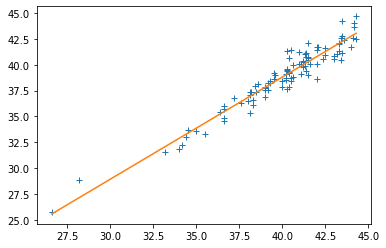

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


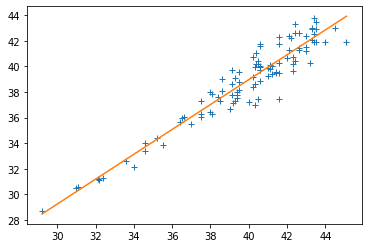

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


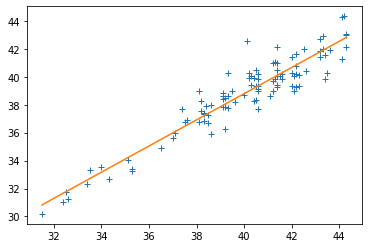

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


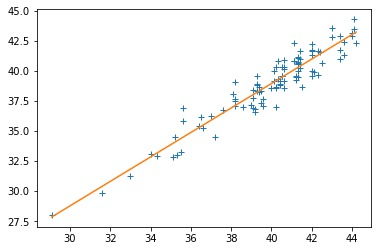

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


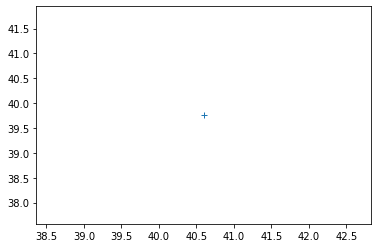

[50,     1] loss: 0.668
[50,    11] loss: 5.212
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


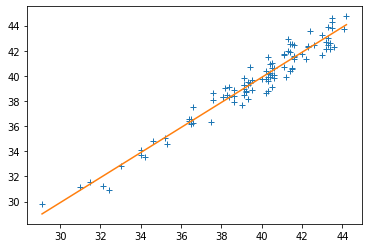

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


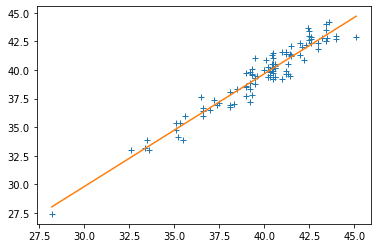

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


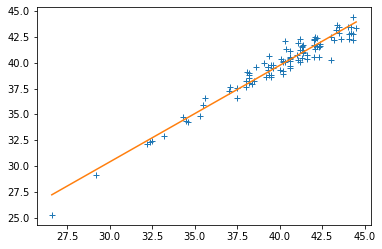

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


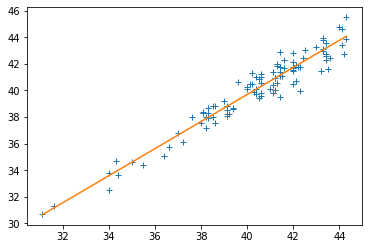

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


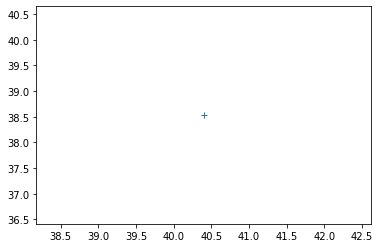

[51,     1] loss: 0.905
[51,    11] loss: 5.708
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


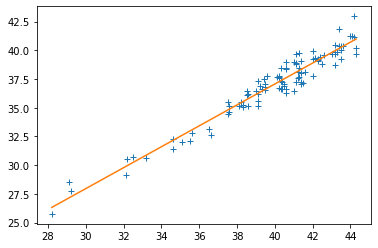

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


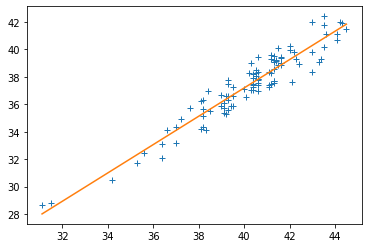

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


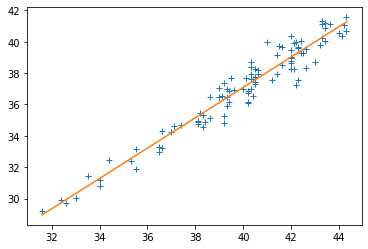

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


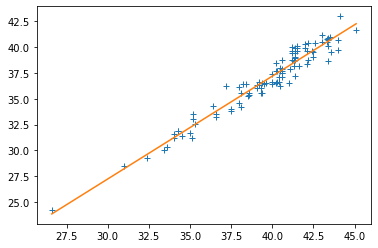

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


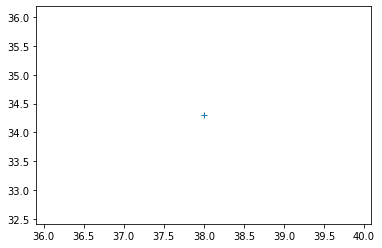

[52,     1] loss: 0.860
[52,    11] loss: 8.944
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


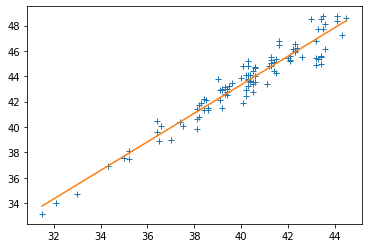

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


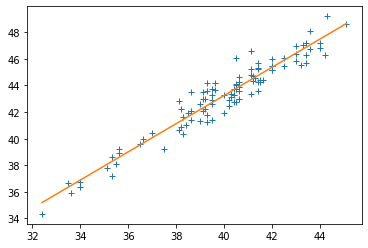

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


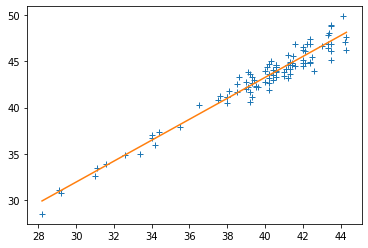

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


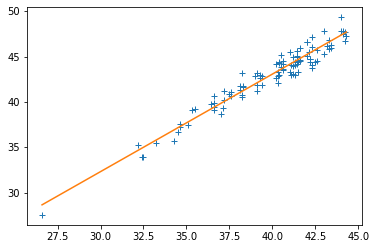

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


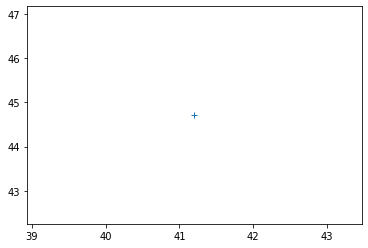

[53,     1] loss: 1.325
[53,    11] loss: 1.753
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


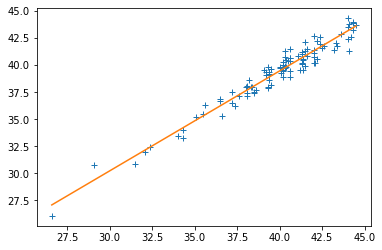

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


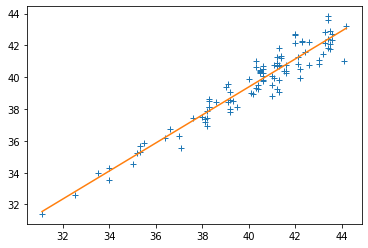

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


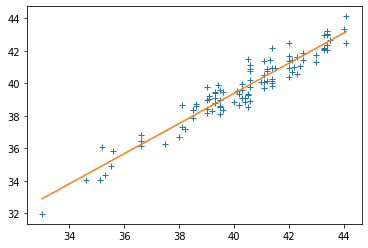

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


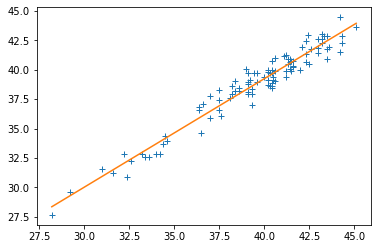

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


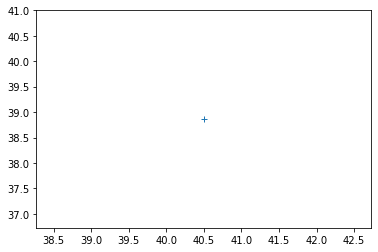

[54,     1] loss: 0.671
[54,    11] loss: 0.834
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


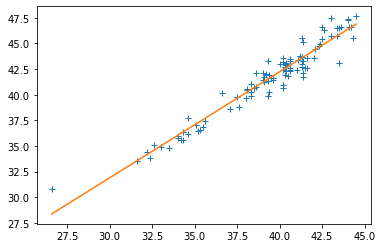

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


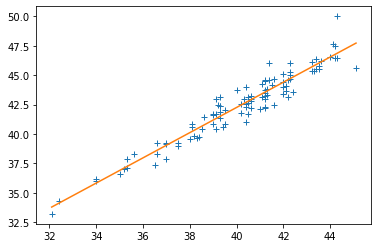

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


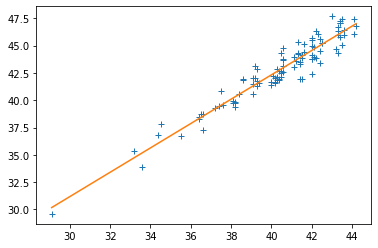

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


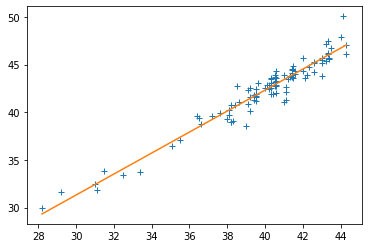

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


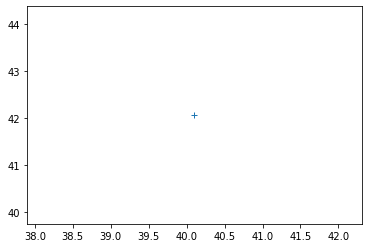

[55,     1] loss: 0.554
[55,    11] loss: 2.698
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


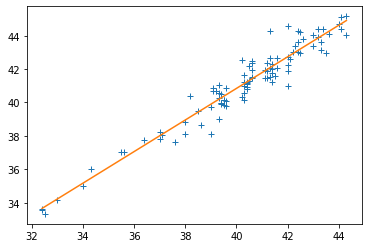

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


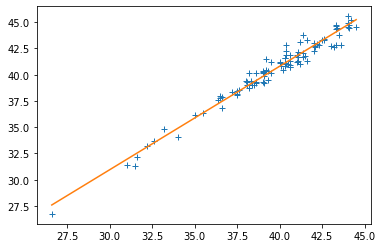

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


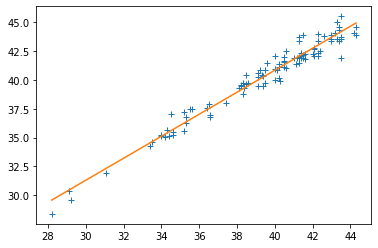

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


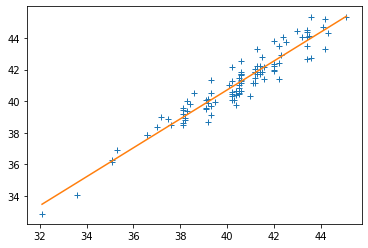

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


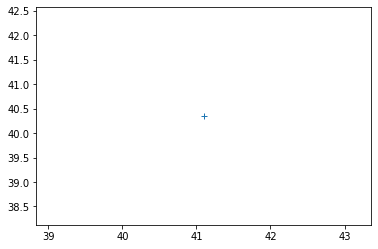

[56,     1] loss: 5.090
[56,    11] loss: 0.473
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


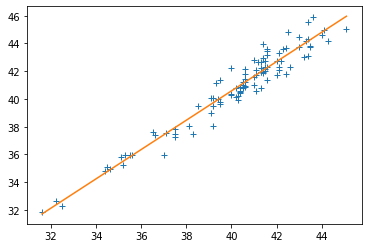

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


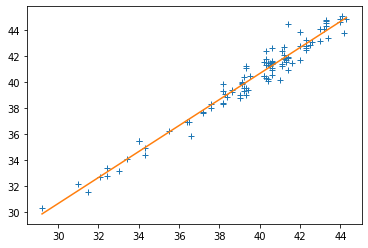

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


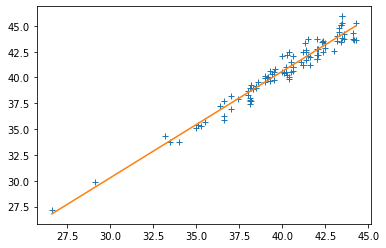

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


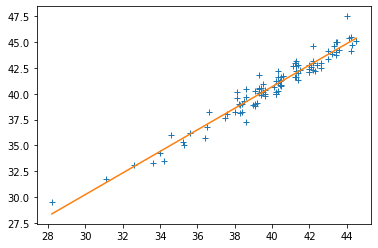

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


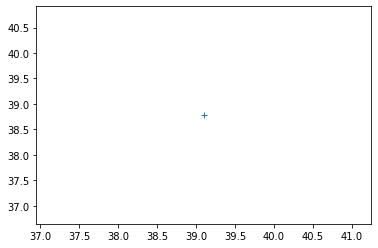

[57,     1] loss: 1.032
[57,    11] loss: 1.564
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


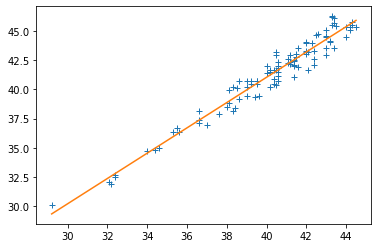

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


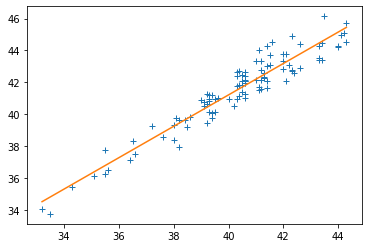

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


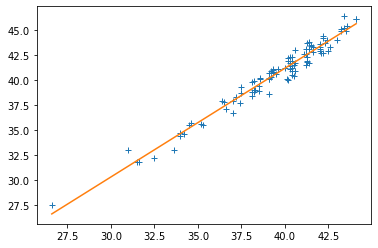

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


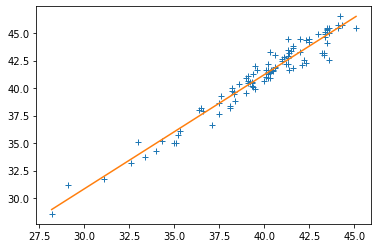

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


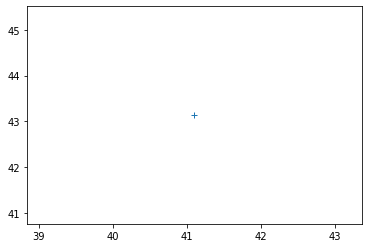

[58,     1] loss: 0.884
[58,    11] loss: 0.352
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


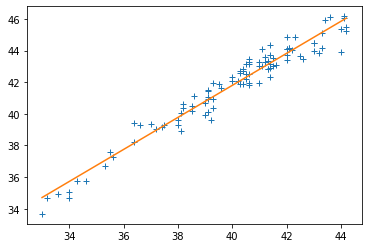

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


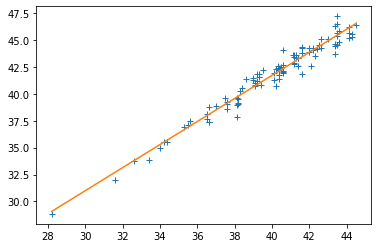

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


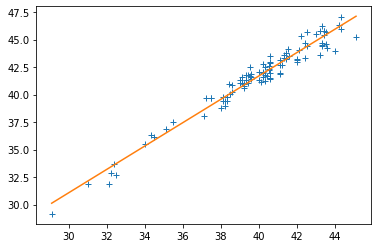

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


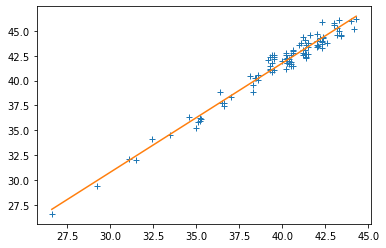

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


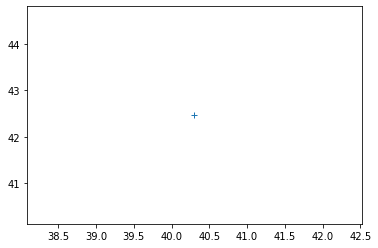

[59,     1] loss: 1.341
[59,    11] loss: 0.752
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


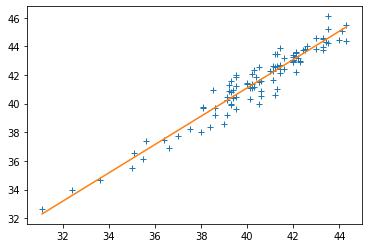

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


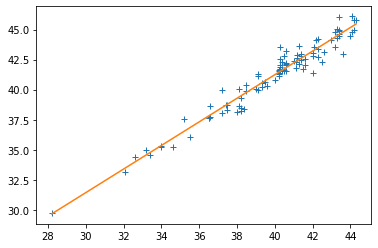

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


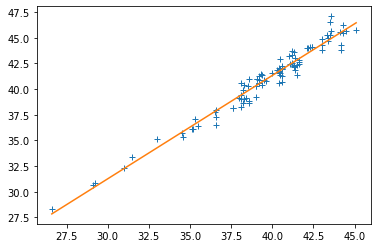

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


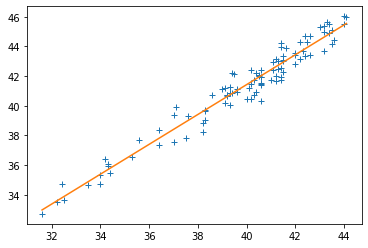

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


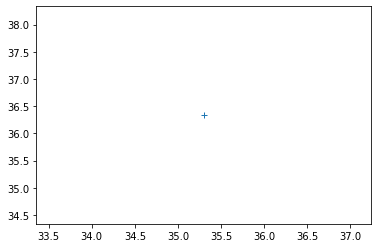

[60,     1] loss: 2.587
[60,    11] loss: 3.288
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


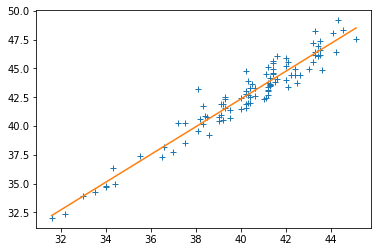

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


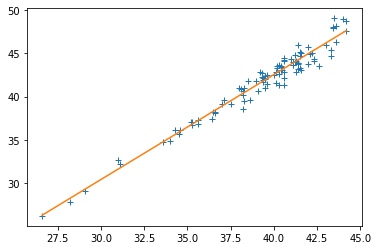

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


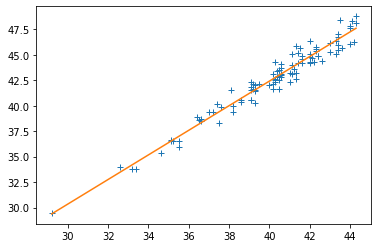

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


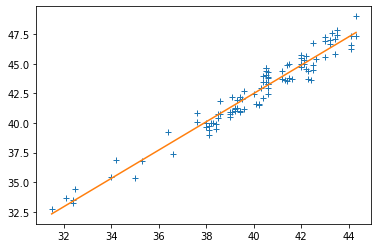

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


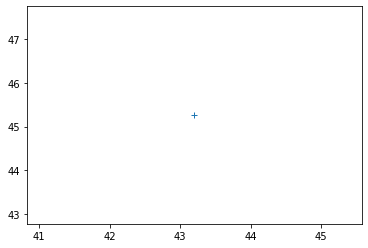

[61,     1] loss: 2.647
[61,    11] loss: 1.821
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


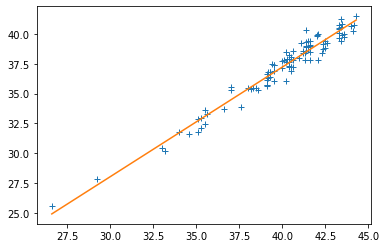

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


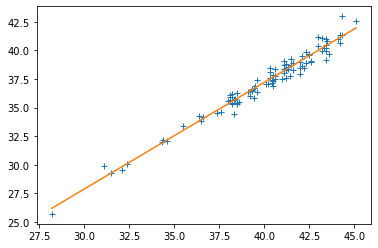

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


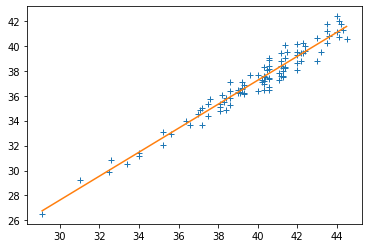

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


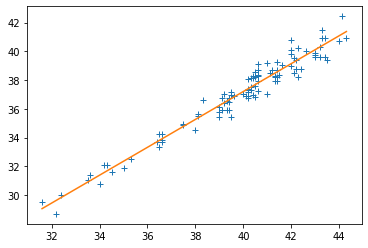

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


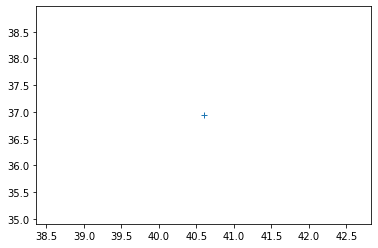

[62,     1] loss: 3.012
[62,    11] loss: 6.365
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


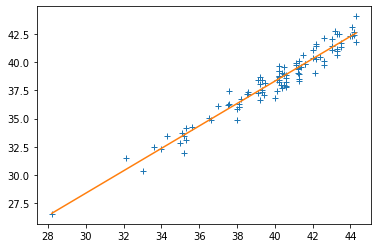

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


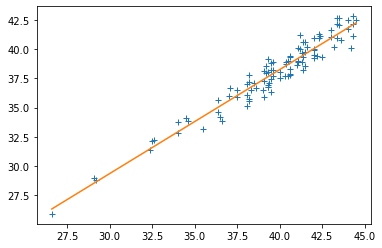

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


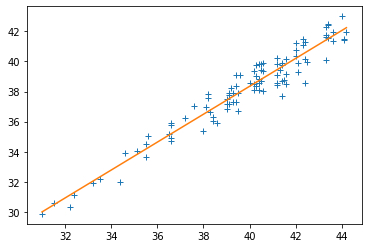

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


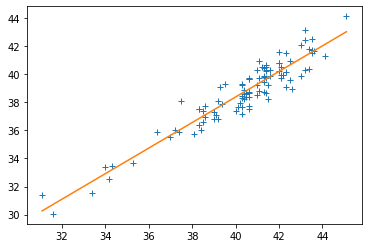

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


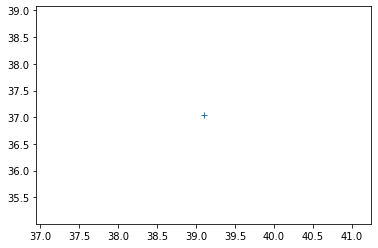

[63,     1] loss: 2.762
[63,    11] loss: 2.965
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


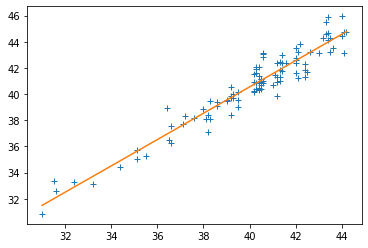

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


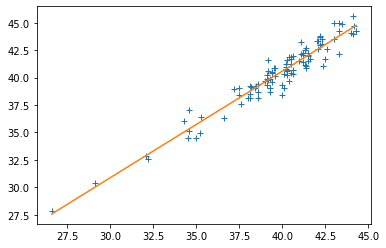

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


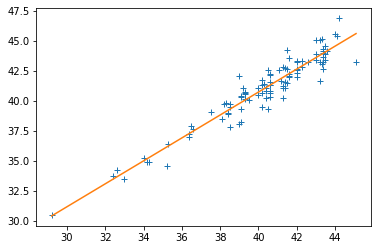

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


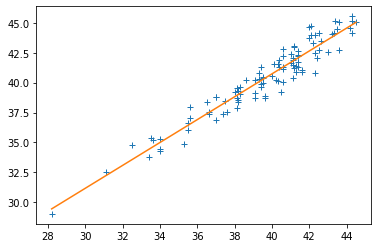

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


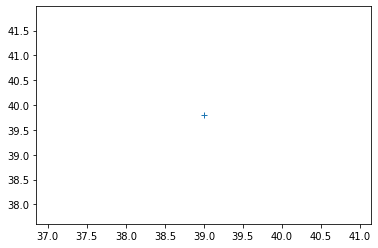

[64,     1] loss: 0.776
[64,    11] loss: 0.562
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


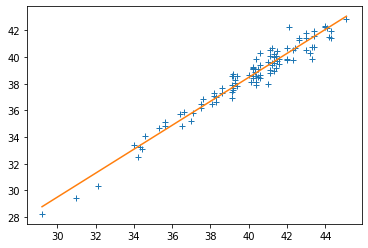

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


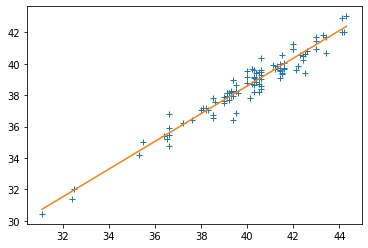

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


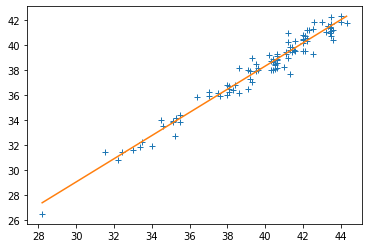

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


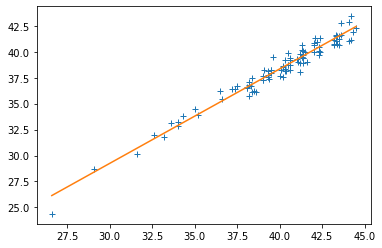

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


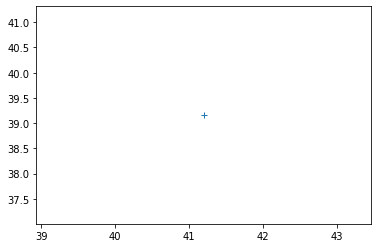

[65,     1] loss: 1.814
[65,    11] loss: 2.676
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


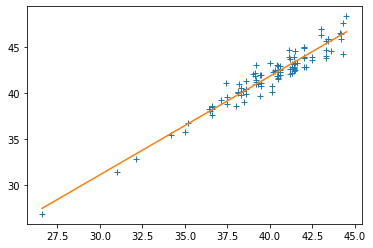

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


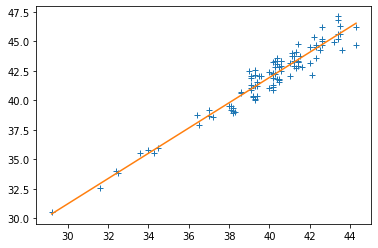

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


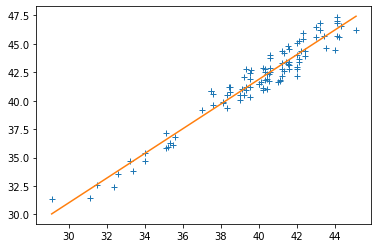

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


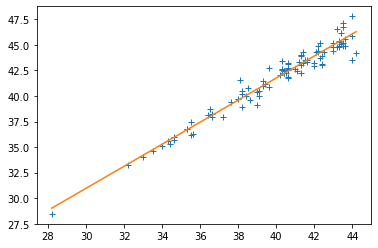

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


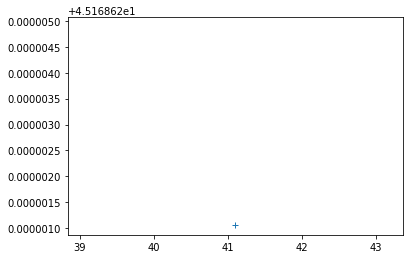

[66,     1] loss: 0.892
[66,    11] loss: 1.695
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


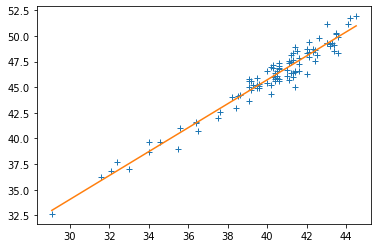

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


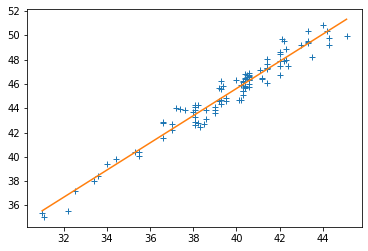

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


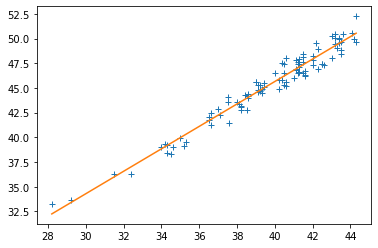

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


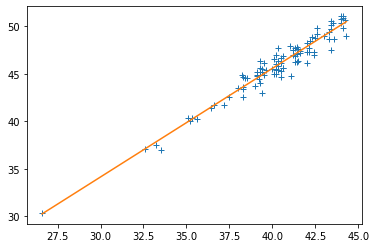

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


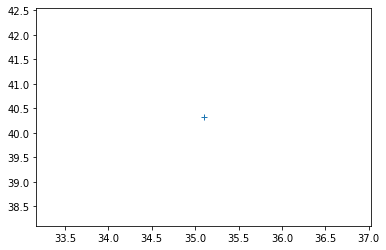

[67,     1] loss: 9.355
[67,    11] loss: 2.701
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


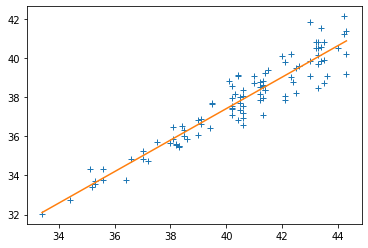

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


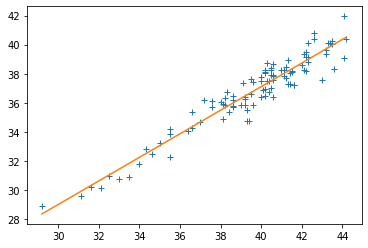

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


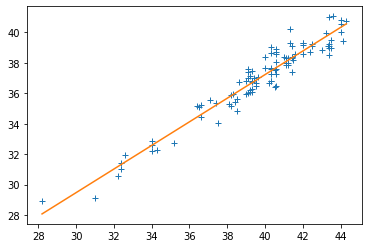

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


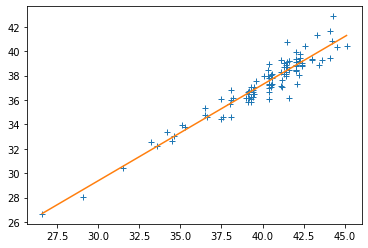

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


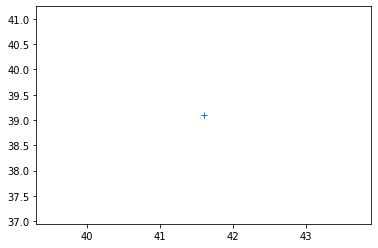

[68,     1] loss: 1.383
[68,    11] loss: 0.633
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


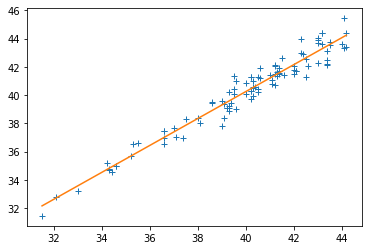

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


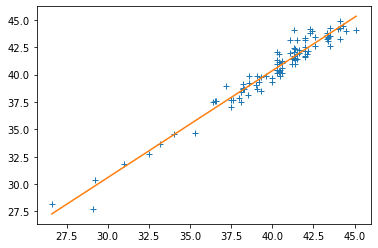

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


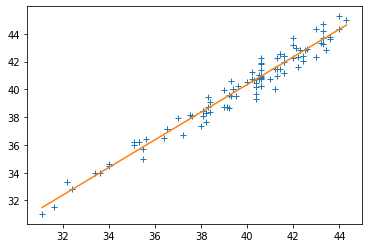

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


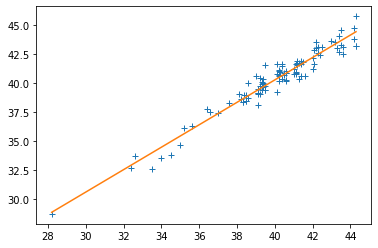

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


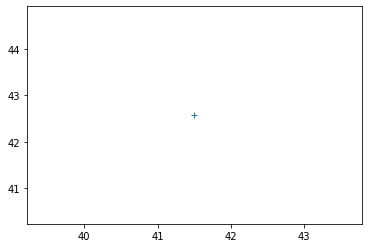

[69,     1] loss: 0.634
[69,    11] loss: 5.431
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


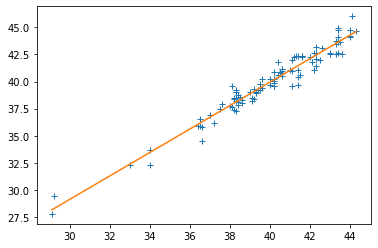

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


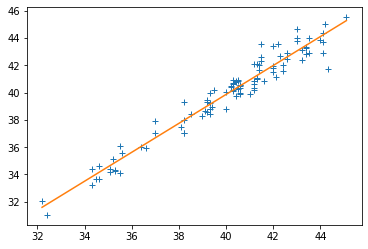

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


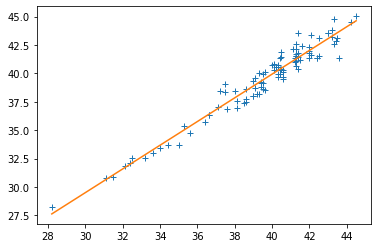

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


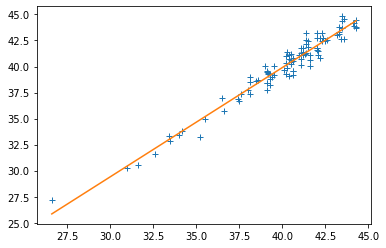

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


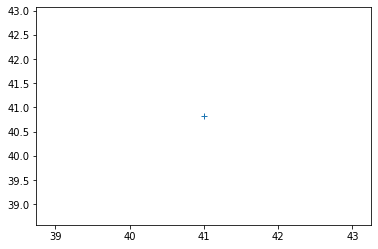

[70,     1] loss: 0.696
[70,    11] loss: 6.212
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


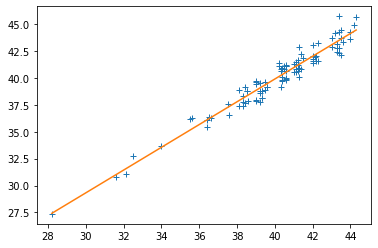

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


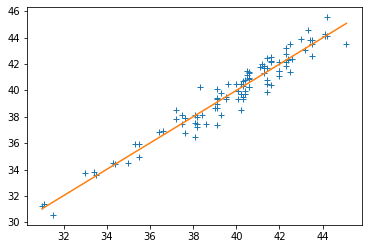

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


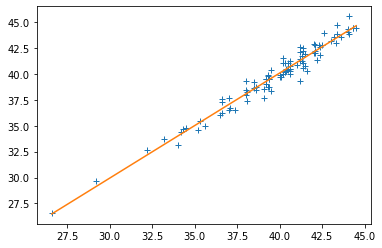

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


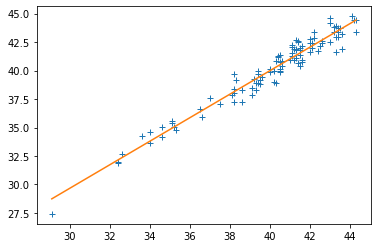

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


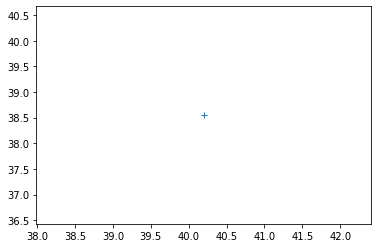

[71,     1] loss: 0.536
[71,    11] loss: 0.897
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


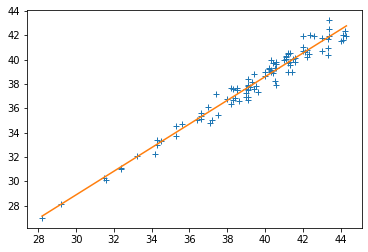

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


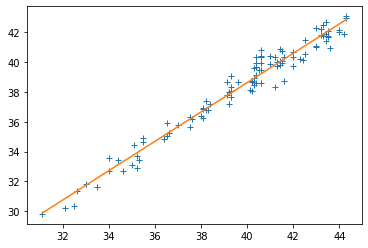

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


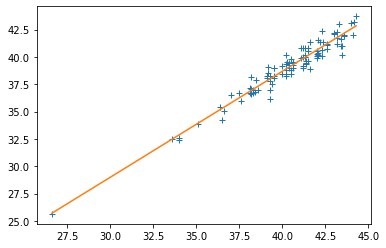

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


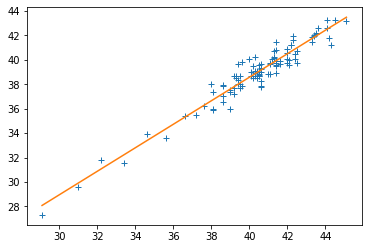

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


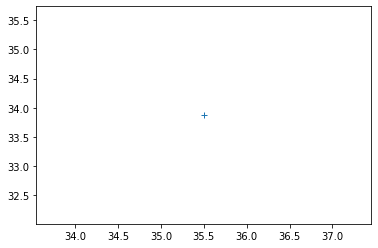

[72,     1] loss: 0.819
[72,    11] loss: 0.732
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


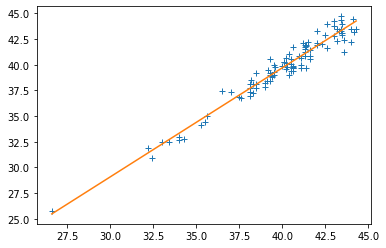

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


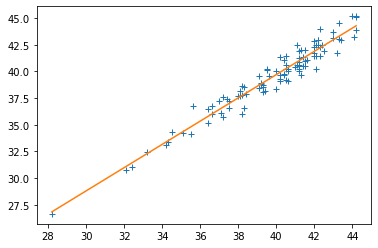

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


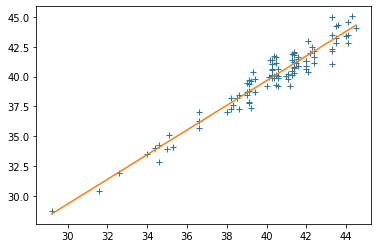

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


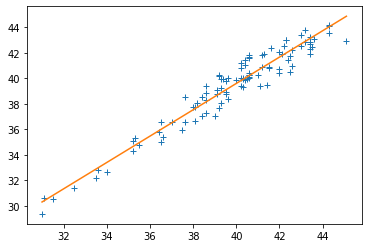

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


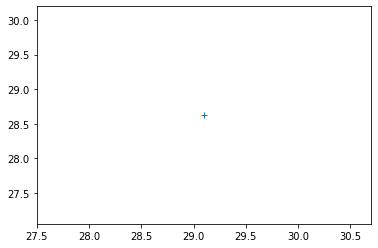

[73,     1] loss: 0.396
[73,    11] loss: 2.370
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


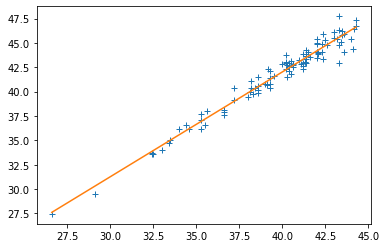

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


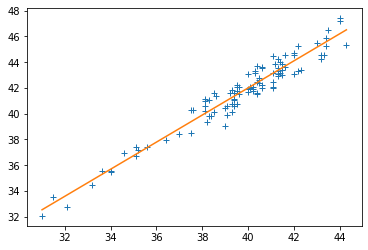

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


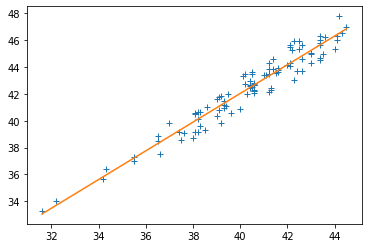

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


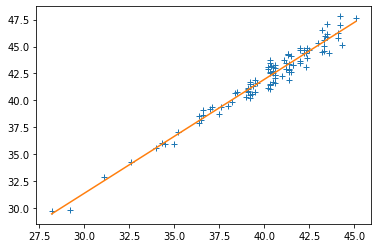

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


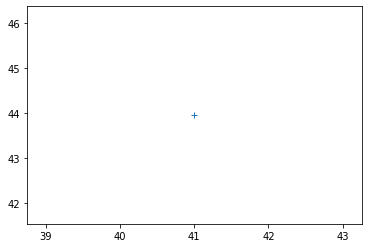

[74,     1] loss: 0.627
[74,    11] loss: 1.144
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


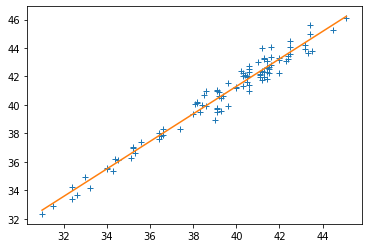

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


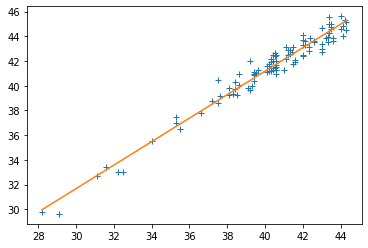

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


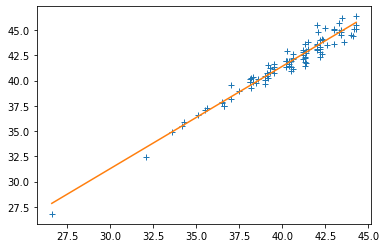

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


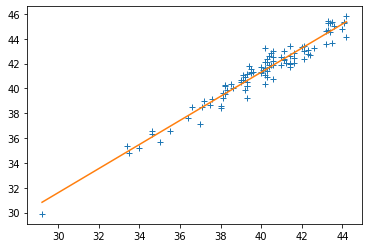

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


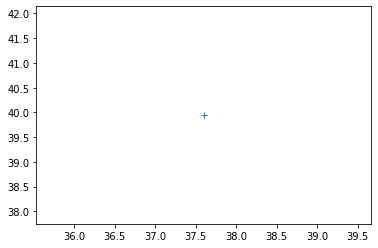

[75,     1] loss: 0.519
[75,    11] loss: 4.059
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


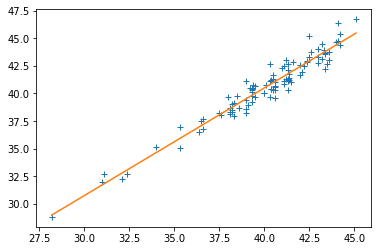

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


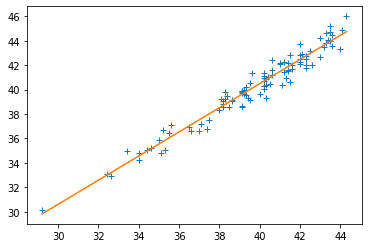

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


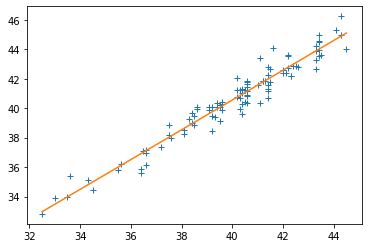

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


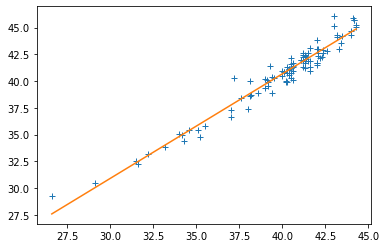

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


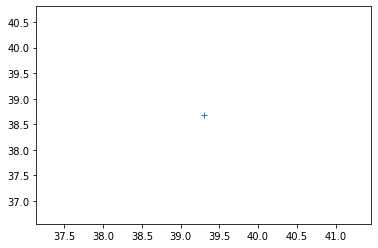

[76,     1] loss: 2.509
[76,    11] loss: 0.489
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


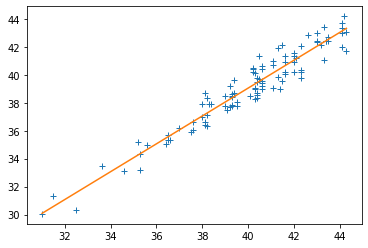

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


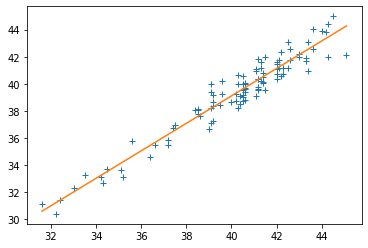

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


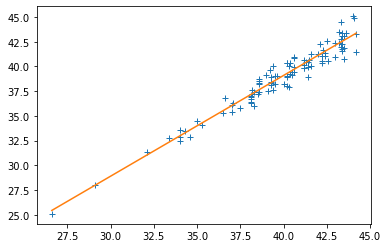

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


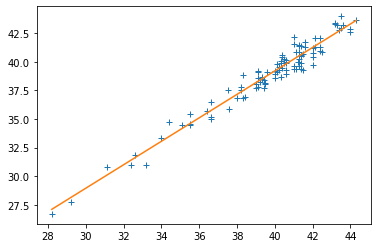

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


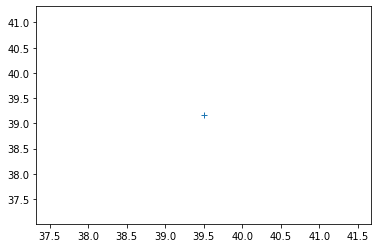

[77,     1] loss: 1.602
[77,    11] loss: 1.172
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


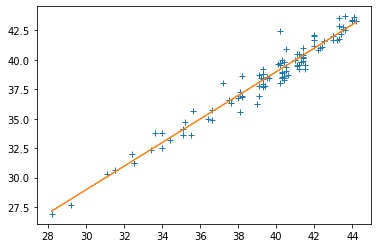

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


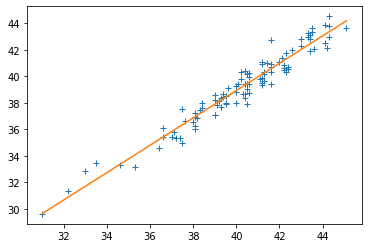

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


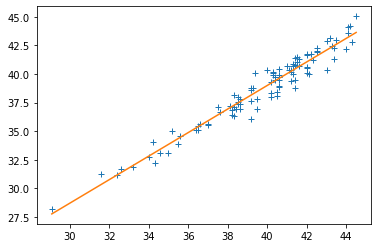

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


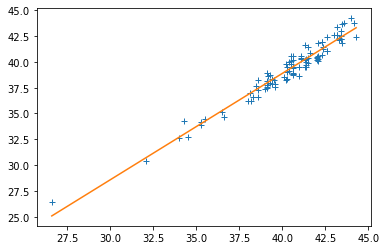

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


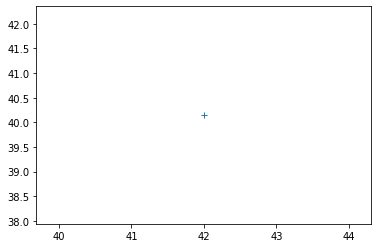

[78,     1] loss: 0.784
[78,    11] loss: 1.177
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


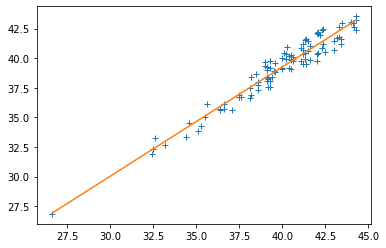

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


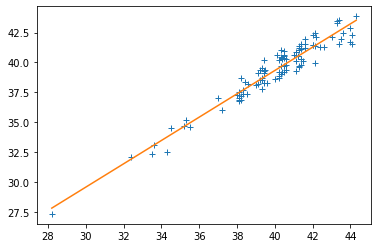

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


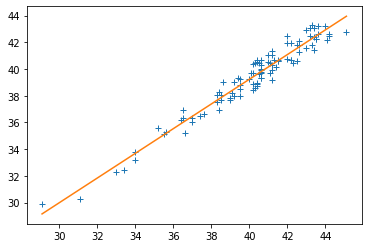

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


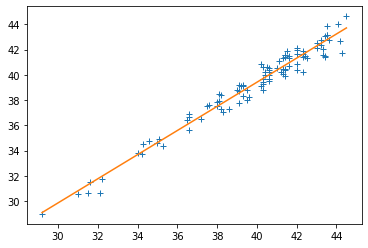

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


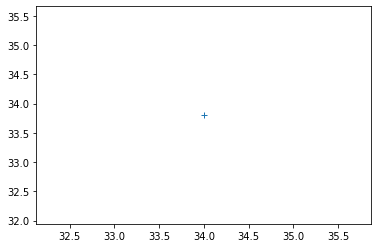

[79,     1] loss: 0.421
[79,    11] loss: 1.197
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


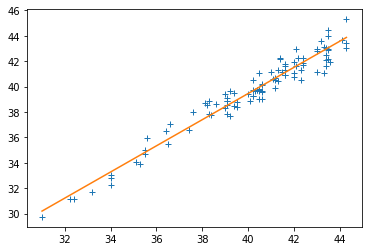

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


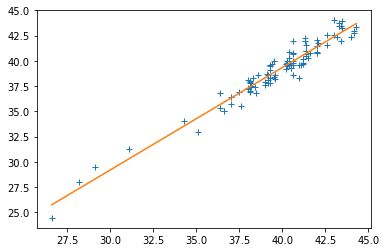

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


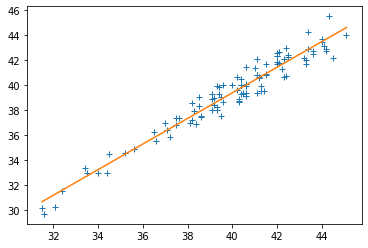

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


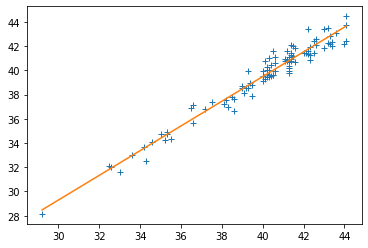

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


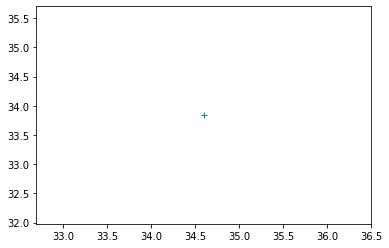

[80,     1] loss: 1.408
[80,    11] loss: 2.072
validation loader 0 torch.Size([101, 3, 240, 320]) torch.Size([101])


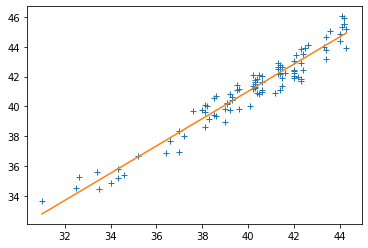

validation loader 1 torch.Size([101, 3, 240, 320]) torch.Size([101])


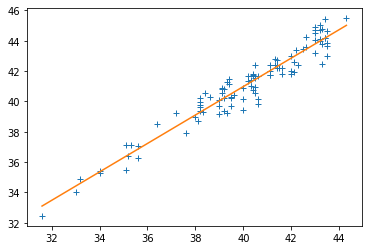

validation loader 2 torch.Size([101, 3, 240, 320]) torch.Size([101])


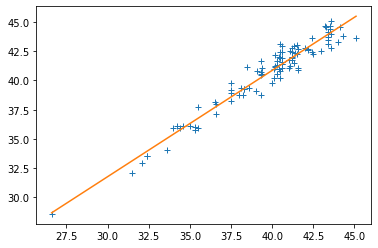

validation loader 3 torch.Size([101, 3, 240, 320]) torch.Size([101])


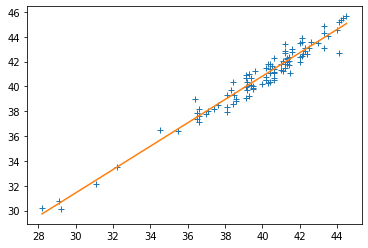

validation loader 4 torch.Size([1, 3, 240, 320]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


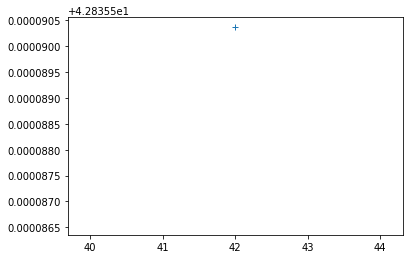

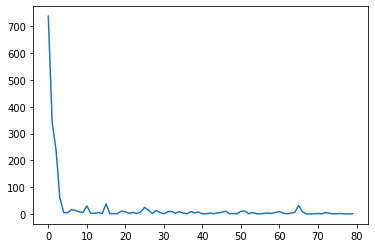

In [13]:
epochs = 80
t0 = time.time()
mean_val_error=[]

for epoch in range(epochs):

    # ----------------------------------- task 5.1 complete training loop ---------------------------
    net.train()
    for i, (data, label) in enumerate(train_dataloader):
        data = data.to(device)
        label = label.to(device)
        #feed the input and acquire the output from network
        x_out = net(data)
        x_out = x_out.squeeze(1)
        
        # clear the gradient
        optimizer.zero_grad()

        #calculating the predicted and the expected loss
        loss = criterion(x_out, label)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))
       
        # ----------------------------------------------------------------------

    val_error = np.zeros(len(val_dataloader))

    # ----------------------------------- task 5.1 complete validation loop ---------------------------
    net.eval()
    for i, (data, label) in enumerate(val_dataloader):
        print('validation loader',i,data.shape,label.shape)
        data = data.to(device)
        label = label.to(device)
        #feed the input and acquire the output from network
        x_out = net(data)
        x_out = x_out.squeeze(1)
        err = criterion(label, x_out)
        # ---------------------------------------------------------------------
        # note this expects variable x_out as the output from the forward pass (with the validation data)
        predictions = x_out.cpu().detach().numpy()
        labels = label.cpu().detach().numpy()
        val_error[i] = err.item()
        plt.plot(labels,predictions,'+')
        plt.plot(np.unique(labels), np.poly1d(np.polyfit(labels, predictions, 1))(np.unique(labels)))
        plt.show()
    mean_val_error.append(np.mean(val_error))
    
    

plt.plot(np.arange(epochs),mean_val_error)
plt.show()


**Total Ex. 5: 10 marks**

(85 to this point)

## Exercise 6 Visualisation (20 marks)

In the final section we will employ visualisation to observe which parts of the image were most important for prediction. First, let us look at the activations. 

Task 6.1 Implement a forward hook that will save and return the activations of a given layer. Use it to plot the mean activations across all validation examples. Note, in this instance, this is a reasonable thing to do, as the data was spatially normalised prior to analysis. 

To do:
1. Create a hook function to return the activations of a given layer (1 mark)
2. Create a hook for the first residual layer (2 marks)
3. Pass a validation batch through the network; the hook function will be called during the forward pass of the layer defined in step 2 (2 marks)
4. average the activations across subjects and visualise the results for the first 10 filters. (3 marks)

(8 marks)


32 10


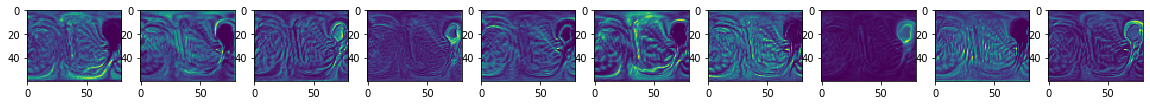

In [14]:
# student code here

# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
    

# Create a hook on the first convolutional layer
net.layer1.register_forward_hook(get_activation('layer1'))

# Get some data
data, _ = next(iter(val_dataloader))
data = data.to(device)

# Run through model again, to save the relavent activation
output = net(data)

# Visualize the activation
act = torch.mean(activation['layer1'], dim=0).squeeze(0)
print(act.size(0), min(act.size(0), 10))

fig, axarr = plt.subplots(1, min(act.size(0), 10), figsize=(20,20))
numberOfPlots = min(act.size(0), 10)
for i in np.arange(numberOfPlots):
    axarr[i].imshow(act.cpu()[i, :, :])

Next use occlusion analysis to determine which parts of the image are most important for the prediction. Adapt the example on occlusion to allow prediction of the areas of your image which most impact your regression prediction. Plot the resulting heatmap for the first 10 images from the validation batch.

(7 marks)

- 3 mark for selecting the correct function and editing to pass the target label and example image from one example in the validation batch
- 2 mark for changing the function to predict the absolute difference between the true label and the prediction (or some other sensible metric)
- 2 mark for correctly selecting a sensible plot function and then plotting for each of the 10 images

torch.Size([3, 240, 320]) tensor(32.4000)
torch.Size([3, 240, 320]) tensor(41.2000)
torch.Size([3, 240, 320]) tensor(41.4000)
torch.Size([3, 240, 320]) tensor(39.1000)
torch.Size([3, 240, 320]) tensor(40.6000)
torch.Size([3, 240, 320]) tensor(38.2000)
torch.Size([3, 240, 320]) tensor(35.5000)
torch.Size([3, 240, 320]) tensor(43.2000)
torch.Size([3, 240, 320]) tensor(41.4000)
torch.Size([3, 240, 320]) tensor(43.5000)


<function matplotlib.pyplot.show>

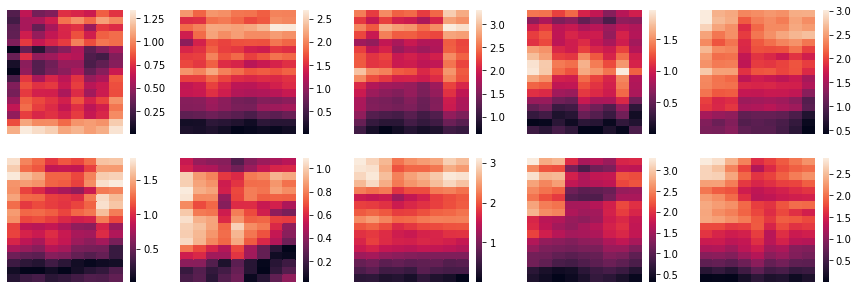

In [15]:
# Student code here
import seaborn as sns

def occludeImage(image, model, heightStart, widthStart, patchSize, label):
    ''' 
    Creates a copy of the image and occludes a patch 
    input:
    image (Pytorch tensor): image to be occluded
    model: Pytorch network model 
    heightStart=starting index on height dimension
    widthStart=start ing index on width dimension
    patchSize: size of patch
    
    output: 
    the occluded image and the probability
    '''
    occludedImage = image.detach().clone()
    heightEnd = heightStart + patchSize
    widthEnd = widthStart + patchSize
    occludedImage[:, heightStart:heightEnd, widthStart:widthEnd] = 0.5

    outputOccluded = model(occludedImage.unsqueeze(0))
    occludedProbability = abs(outputOccluded.item() - label)
    # occludedProb = nn.functional.softmax(outputOccluded, dim=1).tolist()[0][label]

    return occludedImage, occludedProbability

def occlusion(model, image, label, occSize = 50, occStride = 50, occPixel = 0.5):
    print(image.shape,label)
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1] 
  
    #setting the output image width and height
    outputHeight = int(np.ceil((height-occSize)/occStride))
    outputWidth = int(np.ceil((width-occSize)/occStride))
    #create a white image of sizes we defined
    heatmap = torch.zeros((outputHeight, outputWidth))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            hStart = h * occStride
            wStart = w * occStride 
            hEnd = min(height, hStart + occSize)
            wEnd = min(width, wStart + occSize)
            
            if (wEnd) >= width or (hEnd) >= height:
                continue
                
            occludedImage, occludedProbability = occludeImage(image, model, hStart, wStart, occSize, label)
            #setting the heatmap location to probability value
            heatmap[h, w] = occludedProbability

    return heatmap

# Get some data
imageBatch, labelBatch = next(iter(val_dataloader))
imageBatch = imageBatch.to(device)


# Plot
fig = plt.figure(figsize=(15, 5))

for i in range(10):
  heatmap  = occlusion(net, imageBatch[i], labelBatch[i], 150, 10)
  fig.add_subplot(2, 5, i+1)
  imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
  figure = imgplot.get_figure()

plt.show


**Section 6 total 15**

**Coursework Total: 100**